# Exploratory Data Analysis<br> 
### by Ori Rosenthal

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import squarify 
from adjustText import adjust_text
from IPython.display import Image
import datetime
from time import sleep
from time import strftime
from geopy.geocoders import Nominatim
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnchoredText
import matplotlib.patheffects as path_effects

%matplotlib inline

import os
os.environ['PROJ_LIB'] = r'C:\Users\User\Anaconda3\envs\data_env\Library\share'
from mpl_toolkits.basemap import Basemap
import folium
pd.options.display.max_rows = 999


![covid image](https://cdn3.creativecirclemedia.com/wilsontimes/original/20200315-135549-COVID19%20GRAPHICweb.jpg)
Image from cdn3.creativecirclemedia.com

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<u><b>Notes:</b></u><br> 
This notebook presents an exploratory data analysis, for coronavirus pandemic, particularly with advanced visualization.<br>
In order to make it more clearly visible, I have hidden the prompt code from this version.<br>
The full code can be found in my GitHub: <div style="direction:ltr"><a href="https://github.com/Orosenthal/COVID19-eda">COVID19-eda</a></div>
    

The data was extracted from these three sources:
1. <div style="direction:rtl">
    <a href="https://www.worldometers.info/coronavirus/">Worldometers</a>
</div> 
2. <div style="direction:rtl">
    <a href="https://github.com/COVID19Tracking/covid-tracking-data/">COVID Tracking Data</a>
</div> 
3. <div style="direction:rtl">
    <a href="https://en.wikipedia.org/wiki/List_of_countries_by_dependency_ratio/">wikipedia</a>
</div> 
  


In [2]:
print(f'Last update of data sets: {datetime.datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")} (UTC)')

Last update of data sets: 2020-05-14 09:37:45 (UTC)


In [3]:
def get_lat_lon(location):
    '''
    get longitude and latitude from geolocator api
    '''
    geolocator = Nominatim(user_agent="data_covid")
    location = geolocator.geocode(location)
    return(location.longitude, location.latitude)   



def plot_stacked_pct():
    
    
    plt.style.use('seaborn-deep')
    df_pct = df[df['TotalCases'] > 5000][['ActiveCases','TotalRecovered','TotalDeaths']]
    df_pct = (df_pct.T/df_pct.T.sum()*100).T.round(2)
    df_pct = df_pct.sort_values(by='ActiveCases')
    df_pct.plot.barh(stacked=True, figsize=(17,15));
    plt.yticks(fontsize=15);plt.margins(x=0,y=0);plt.grid(b=None);plt.xticks([], []);plt.ylabel("");
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0),ncol=3);
    plt.title(f'Current status: Active, Recovered, Deathes ({datetime.date.today()})', fontsize=25);


def pair_corr_plot(df, tc_threshold = 10000, x ='MedAg', y='Deaths/Cases'):

    plt.style.use('bmh')
    fig, ax = plt.subplots(figsize = (16, 10))
    df_age = df[df['TotalCases']>tc_threshold].reset_index().sort_values(x, ascending=False)
    df_age['Deaths/Cases'] = df_age['TotalDeaths'] / df_age['TotalCases']
    corr = df_age[x].corr(df_age[y]).round(3)
    sns.regplot(x, y, data=df_age, label='Country');
    text = [plt.text(x, y, z, color='r', size=15) for x, y, z in zip(df_age[x],df_age[y],df_age['Country'])]
    plt.title(f'COVID19 - Countries by {x} Vs. {y}',pad=15,weight = 'semibold')
    sns.set(font_scale=1.4);
    anchored_text = AnchoredText(f"Correlation: {corr}", loc=2,prop=dict(fontweight="bold"))
    ax.add_artist(anchored_text);
    adjust_text(text);
    
def countries_tpr_recovery():
    

    fig, ax = plt.subplots(figsize = (20, 14))
    df_ir = df[(df['Tests/ 1M pop'] > 5000) & (df['TotalCases']>5000)].reset_index()
    df_ir['recoverd\cases'] = df_ir['TotalRecovered'] / (df_ir['TotalCases'] - df_ir['TotalDeaths'])
    df_ir['Cases_tests_recoverd_retio'] = df_ir['recoverd\cases'] * df_ir['Cases/Test']
    df_ir = df_ir.sort_values(by='Cases/Test')
    median_ir = df_ir['Cases/Test'].median()
    ax = sns.barplot(x= "Cases/Test", y = "Country", data = df_ir, palette=("OrRd"), label='Test positivity rate (cases/tests)')
    ax2 = sns.barplot(x= "Cases_tests_recoverd_retio", y = "Country", data = df_ir, color='g', label='Current Recovery rate')
    plt.title(f'COVID19 - Confirmed cases (Test positive rate) & Recovery Rate by Countries ({datetime.date.today()})',
              fontsize=20,pad=12,weight ='semibold')
    ax3 = plt.axvline(median_ir, linestyle='--', c='grey', alpha=0.7,
                      label=f'Median positivity rate: {np.round(median_ir*100,2)}%')
    plt.gca().legend(prop={'size': 20})
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    plt.yticks(fontsize=20); plt.xlabel('Test positive rate')
    leg = ax.get_legend()
    leg.legendHandles[1].set_color('brown'); sns.set_context("poster");
    
    
def countries_cases_recovery():
    

    fig, ax = plt.subplots(figsize = (20, 14))
    df_ir = df[df['TotalCases']>10000].reset_index()
    df_ir['recoverd/1M'] = df_ir['TotalRecovered'] / (df_ir['Population (2020)'] /1_000_000)

    # df_ir['Cases_tests_recoverd_retio'] = df_ir['recoverd\cases'] * df_ir['Cases/Test']
    df_ir = df_ir.sort_values(by='Tot Cases_1M')
    ax = sns.barplot(x= "Tot Cases_1M", y = "Country", data = df_ir, palette=("OrRd"), label='Cases per million')
    ax2 = sns.barplot(x= "recoverd/1M", y = "Country", data = df_ir, color='g', label='Recovery per million')
    plt.title(f'COVID19 - Confirmed Cases & Recovery per million by Countries ({datetime.date.today()})',
              fontsize=20,pad=12,weight ='semibold')
    ax3 = plt.axvline(df_ir['Tot Cases_1M'].median(), linestyle='--', c='r', alpha=0.8,
                      label=f'Median cases per million: {df_ir["Tot Cases_1M"].median():,}')
    ax4 = plt.axvline(df_ir['recoverd/1M'].median(), linestyle='--', c='g', alpha=0.8,
                      label=f'Median recovery per million: {np.round(df_ir["recoverd/1M"].median())}')
    plt.gca().legend(prop={'size': 20})
    # ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    plt.yticks(fontsize=20); plt.xlabel('Cases per Million')
    leg = ax.get_legend()
    leg.legendHandles[2].set_color('brown'); sns.set_context("poster");
    
    
    
def countries_tpr_tr():
    
    
    fig, ax = plt.subplots(figsize = (15, 10))
    df_ir = df[df['TotalCases']>10000].reset_index()
    df_ir = df_ir.sort_values(by='Tests/ 1M pop')
    ax = sns.barplot(x= "Country" , y = "Tests/ 1M pop", data = df_ir, color='g', label='Test per million')
    plt.xticks(rotation=70, fontsize=15); 
    plt.yticks(color='blue', size=20)
    ax2 = ax.twinx()
    ax2 = sns.pointplot(x= "Country", y = "Cases/Test", data = df_ir, color='r', label='Tests positivity rate')
    ax.yaxis.set_ticks_position("right")
    ax2.yaxis.set_ticks_position("left")
    ax.set_ylabel('Test Poitive Rate (%)', fontsize=16, color='red', size=20,labelpad=35)
    ax2.set_ylabel('Tests per Million', fontsize=16, color='green', size=20, rotation=270, labelpad=60)
    ax.set_ylabel('Test Poitive Rate (%)', fontsize=16, color='red', size=20,labelpad=50)
    ax2.set_ylabel('Tests per Million', fontsize=16, color='green', size=20, rotation=270, labelpad=60)
    plt.title(f'COVID19 - Test positive rate Vs Test per million',fontsize=25,pad=12,weight ='semibold');
    ax.tick_params(axis='y', color='r', labelsize=10)
    plt.yticks(color='red', size=15);ax2.grid(False);
    

def worst_countries():

    
    import matplotlib.patheffects as path_effects
    worst_countries = df[df['Population (2020)']>1_000_000].sort_values('Deaths/1M pop',ascending=False)
    worst_countries = worst_countries.head(round(0.1 * len(worst_countries)))

    median_cases = worst_countries['Tot Cases_1M'].median()
    median_deaths = worst_countries['Deaths/1M pop'].median()
    fig, ax = plt.subplots(figsize=(16,9), dpi= 80)
    sns.scatterplot(x='Tot Cases_1M', y='Deaths/1M pop', data=worst_countries, s=40, color='darkblue');
    text = [plt.text(x, y, z, color='w', size=20,path_effects=[path_effects.Stroke(linewidth=3,
        foreground='darkblue'), path_effects.Normal()]) \
            for x, y, z in zip(worst_countries['Tot Cases_1M'], worst_countries['Deaths/1M pop'],worst_countries.index)]
    plt.title(f'COVID19 - Worst hit countries Cases Vs. Deaths per 1M \n(top 10% countries with the highest death'\
              'rate per million)', color='dimgray', pad=15,fontsize=17, weight = 'semibold')
    ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
    plt.margins(x=0,y=0)
    ax.patch.set_facecolor('red');ax.patch.set_alpha(0.6);
    ax.grid(False)
    sns.set(font_scale = 1.5);
    ax.tick_params( colors='dimgray')
    adjust_text(text);

def usa_cases_ts():
    
    
    usa_positive = usa_covid19.groupby('date')[['positive','positiveIncrease']].sum()
    usa_positive = usa_positive[usa_positive.index >= '2020-03-01'].reset_index()
    plt.style.use('seaborn-deep')
    fig, ax = plt.subplots(figsize=(16,9))
    plt.bar(usa_positive['date'], height=usa_positive['positiveIncrease'], width=0.9);
    plt.xticks(fontsize=17,rotation=45);
    plt.yticks(color='blue', size=20)
    plt.xlim(usa_positive['date'].min().date(),usa_positive['date'].max().date()++ datetime.timedelta(2))
    plt.title('COVID19 - Cases in United States', fontsize=25,pad=15,weight ='semibold')
    ax.set_ylabel('Daily Positive Increase', fontsize=16, color='blue', size=20,rotation=360)
    ax.yaxis.set_label_coords(-0.05,1.04)

    ax2 = ax.twinx()
    plt.plot(usa_positive['date'],usa_positive['positive'], lw=3.5, color='r', marker='.', markersize=20 )
    plt.yticks(color='red', size=20)
    plt.ylim(0,(usa_positive['positive'].max()*1.2))
    ax2.set_ylabel('Total Positive Cases', fontsize=16, color='red', size=20, rotation=360, labelpad=35)
    ax2.yaxis.set_label_coords(+1.05,1.08)
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))); 
    ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))));
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3));
    plt.grid(b=None);

    
def us_positive_t20():
    

    fig, ax = plt.subplots(figsize = (18, 14))
    ax = sns.barplot(x="positive",y="state",data=usa_covid19.groupby('state')[['positive']].first()\
            .sort_values(by='positive').reset_index()[-20:],palette=("OrRd"), label='Current Cases'); 
    ax2 = sns.barplot(x="positive",y="state",data=usa_covid19lw.groupby('state')[['positive']].first()\
            .sort_values(by='positive').reset_index()[-20:],palette=("GnBu"), label='7 Days ago'); 
    plt.yticks(fontsize=20); plt.xticks(fontsize=20);
    ax.set_xlabel("Positive Cases",fontsize=20, color='gray', weight ='semibold')
    ax.set_ylabel("States",fontsize=20, color='gray',weight ='semibold')
    plt.title(f'COVID19 - US - Top 20 Most Infected States (last update: {usa_covid19.date[0].date()})',
          fontsize=20, weight ='semibold');
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))));
    plt.gca().legend(prop={'size': 20}); leg = ax.get_legend()
    leg.legendHandles[0].set_color('brown');leg.legendHandles[1].set_color('royalblue'); sns.set_context("poster");




    
def positive_cases_plot(df,state):
    
    state_c = df[df['state'] ==state][['date','positiveIncrease','deathIncrease']].sort_values(by='date')\
    .reset_index(drop=True).dropna()
    state_c['total_cases'] = state_c['positiveIncrease'].cumsum()
    plt.style.use('seaborn-deep')
    fig, ax = plt.subplots(figsize=(16,5))
    plt.bar(state_c['date'], height=state_c['positiveIncrease'], width=0.9,alpha=0.9);
    plt.xlim(state_c['date'].min().date(),state_c['date'].max().date() + datetime.timedelta(2))
    plt.xticks(fontsize=17,rotation=45);
    plt.yticks(color='blue', size=20)
    plt.margins(x=0.04)
    plt.title(f'COVID19 - Cases in {state}', fontsize=25,pad=15,weight ='semibold')
    ax.set_ylabel('Daily Positive Increase', fontsize=16, color='blue', size=20,rotation=360)
    ax.yaxis.set_label_coords(-0.05,1.04)
    ax.grid(False)
    ax2 = ax.twinx()
    plt.plot(state_c['date'],state_c['total_cases'], lw=3.5, color='r', marker='.', markersize=20)
    plt.yticks(color='red', size=20); ax2.grid(False)
    ax2.set_ylabel('Total Positive Cases', fontsize=16, color='red', size=20, rotation=360, labelpad=35)
    ax2.yaxis.set_label_coords(+1.05,1.1)
    at = AnchoredText(f"Total Positive Cases: {int(state_c['total_cases'].iloc[-1]):,}",
                  prop=dict(size=15, color='r',fontweight="bold"), frameon=True, loc='upper left',)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))); 
    ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))));
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))    
    
    
def test_positive_rate_plot():
    
    
    usa_test = usa_covid19.groupby('date')[['positiveIncrease','totalTestResultsIncrease']].sum()
    usa_test = usa_test[usa_test.index >= '2020-03-01'].reset_index()
    usa_test['tpr'] = usa_test['positiveIncrease'] / usa_test['totalTestResultsIncrease']
    usa_tpr_ma = usa_test['tpr'].rolling(5).mean()
    plt.style.use('seaborn-deep')
    fig, ax = plt.subplots(figsize=(16,9))
    plt.bar(usa_test['date'], height=usa_test['totalTestResultsIncrease'], width=0.9,
            color='grey',label='US Daily total tests');
    plt.bar(usa_test['date'], height=usa_test['positiveIncrease'],color='r', width=0.9, label='US Daily positive tests')
    plt.xticks(fontsize=17,rotation=45);
    plt.yticks(color='grey', size=20)
    # plt.xlim(usa_positive['date'].min().date(),usa_positive['date'].max().date()++ datetime.timedelta(2))
    # plt.title('COVID19 - Cases in United States', fontsize=25,pad=15,weight ='semibold')
    ax.set_ylabel('Daily Tests', fontsize=16, color='grey', size=20,rotation=360)
    ax.yaxis.set_label_coords(-0.05,1.04)

    ax2 = ax.twinx()
    plt.plot(usa_test['date'], usa_tpr_ma, lw=3.5, color='black', label='Test positive rate\n5-day moving average')
    plt.yticks(color='red', size=20)
    # plt.ylim(0,(usa_positive['positive'].max()*1.2))
    ax2.set_ylabel('Test Positive Rate', fontsize=16, color='red', size=20, rotation=360, labelpad=35)
    ax2.yaxis.set_label_coords(+1.05,1.08)
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))); 
    ax2.set_yticklabels(['{:,.0%}'.format(x) for x in ax2.get_yticks()])
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2));
    plt.grid(b=None);
    ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.1),ncol=3);
    ax2.legend(loc='upper center', bbox_to_anchor=(0.25, 1.1),ncol=3);
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3));



def positive_cases_plot(df,state):
    
    
    plt.style.use('seaborn-deep')
    state_c = df[df['state'] ==state][['date','positiveIncrease','deathIncrease']].sort_values(by='date')\
    .reset_index(drop=True).dropna()
    state_c['total_cases'] = state_c['positiveIncrease'].cumsum()
    plt.style.use('seaborn-deep')
    fig, ax = plt.subplots(figsize=(16,5))
    plt.bar(state_c['date'], height=state_c['positiveIncrease'], width=0.9,alpha=0.9);
    plt.xlim(state_c['date'].min().date(),state_c['date'].max().date() + datetime.timedelta(2))
    plt.xticks(fontsize=17,rotation=45);
    plt.yticks(color='blue', size=20)
    plt.margins(x=0.04)
    plt.title(f'COVID19 - Cases in {state}', fontsize=25,pad=15,weight ='semibold')
    ax.set_ylabel('Daily Positive Increase', fontsize=16, color='blue', size=20,rotation=360)
    ax.yaxis.set_label_coords(-0.05,1.04)
    ax.grid(False)
    

    ax2 = ax.twinx()
    plt.plot(state_c['date'],state_c['total_cases'], lw=3.5, color='r', marker='.', markersize=20)
    plt.yticks(color='red', size=20); ax2.grid(False)
    ax2.set_ylabel('Total Positive Cases', fontsize=16, color='red', size=20, rotation=360, labelpad=35)
    ax2.yaxis.set_label_coords(+1.05,1.1)
    at = AnchoredText(f"Total Positive Cases: {int(state_c['total_cases'].iloc[-1]):,}",
                  prop=dict(size=15, color='r',fontweight="bold"), frameon=True, loc='upper left',)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))); 
    ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))));
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
    
    
def top_20_infected():
    

    fig, ax = plt.subplots(figsize = (18, 14))
    ax = sns.barplot(x="positive",y="state",data=usa_covid19.groupby('state')[['positive']].first()\
                .sort_values(by='positive').reset_index()[-20:],palette=("OrRd"), label='Current Cases'); 
    ax2 = sns.barplot(x="positive",y="state",data=usa_covid19lw.groupby('state')[['positive']].first()\
                .sort_values(by='positive').reset_index()[-20:],palette=("GnBu"), label='7 Days ago'); 
    plt.yticks(fontsize=20); plt.xticks(fontsize=20);
    ax.set_xlabel("Positive Cases",fontsize=20, color='gray', weight ='semibold')
    ax.set_ylabel("States",fontsize=20, color='gray',weight ='semibold')
    plt.title(f'COVID19 - US - Top 20 Infected States (last update: {usa_covid19.date[0].date()})',fontsize=20,
              weight ='semibold');
    text = [plt.text(y+2000, x, "{:,}".format(int(y)),color='black', size=17,
                     path_effects=[path_effects.withSimplePatchShadow()]) for x, y in enumerate(usa_top20['positive'])]
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))));
    plt.xlim(0, usa_top20['positive'].max()*1.1);plt.gca().legend(prop={'size': 20}); leg = ax.get_legend()
    leg.legendHandles[0].set_color('brown');leg.legendHandles[1].set_color('royalblue'); sns.set_context("poster");


In [4]:
import requests

url = 'https://www.worldometers.info/coronavirus/#countries'
url2 = 'https://www.worldometers.info/world-population/population-by-country/'
url3 = 'https://github.com/COVID19Tracking/covid-tracking-data/raw/master/data/states_daily_4pm_et.csv'
url4 = 'https://en.wikipedia.org/wiki/OECD'
r1 = requests.get(url)
r2 = requests.get(url2)

a = pd.read_html(r1.text)[0]
b = pd.read_html(r2.text)[0]
usa_covid19 = pd.read_csv(url3, parse_dates=['date'])
oecd_countries = pd.read_html(url4)[5]['Country'].to_list()

In [5]:
# Main data table from www.worldometers
# a.head()

In [6]:
# Secondary table from www.worldometers with features on each country
# b.head()

<!-- <u><b>Note</b></u>: Our main data table for corona virus world data is table <b>a</b>, I download table <b>b</b> also to add some different features to the countries (median age, urban population. etc..). Now, since we're going to merge the two data frames together, we need to check if we have the same country name and the same column name. -->

In [7]:
# len(a), len(b)

In [8]:
# [i for i in a['Country,Other'] if i not in b['Country (or dependency)'].values]

In [9]:
# pd.DataFrame([[i for i in a['Country,Other'] if i not in b['Country (or dependency)'].values],
#               [j for j in b['Country (or dependency)'] if j not in a['Country,Other'].values]]).T

In [10]:
# Fix columns name
a.rename(columns={'Country,Other':'Country',
                  "Tot Cases/1M pop":"Tot Cases_1M pop",
                  "Tot Deaths/1M pop":"Tot Deaths_1M pop",
                  "Serious,Critical":"Serious",
                  "Tot\xa0Cases/1M pop":"Tot Cases_1M"}, inplace=True)

b.rename(columns={'Country (or dependency)':'Country', 'Med. Age':'MedAg'}, inplace=True)

b = b[b['Country'] !='Congo']

# Replace (from DataFrame above) country names with a dictionary before joining together 
b.Country.replace({'United Arab Emirates':'UAE', "Côte d'Ivoire": 'Ivory Coast', 'DR Congo':'Congo',
                   'State of Palestine':'Palestine','Central African Republic':'CAR',
                   'Sao Tome & Principe':'Sao Tome and Principe','St. Vincent & Grenadines':'St. Vincent Grenadines',
                   'Saint Kitts & Nevis':'Saint Kitts and Nevis','Saint Barthelemy':'St. Barth',
                   'Saint Pierre & Miquelon': 'Saint Pierre Miquelon', 'Czech Republic (Czechia)':'Czech Republic',
                  }, inplace= True)
a.Country.replace({'USA':'United States','UK':'United Kingdom', 'S. Korea':'South Korea', 'Czechia':'Czech Republic'},
                 inplace=True)
# 'Diamond Princess' and 'MS Zaandam' are cruise ships, Vatican City wasnt found on DataSet b,
# They will be removed from the df merge later, with 'world' (which is an aggregation row), 
# and also China due to the circulation of false Chinese data

In [11]:
# merge a and b to one data set
df = a.merge(b)

In [12]:
# df.head()

In [13]:
df.drop(['#','Yearly Change','NewDeaths','Migrants (net)','Land Area (Km²)','World Share','Net Change','Land Area (Km²)'],
        axis=1, inplace=True) # Drop columns

In [14]:
df = df.set_index('Country')

In [15]:
# Change data types
df['Urban Pop %'] = df['Urban Pop %'].str.replace("%","").replace("N.A.",np.nan).astype('float')
df['Density (P/Km²)'] = df['Density (P/Km²)'].astype('int64')
df['Fert. Rate'] = df['Fert. Rate'].replace("N.A.",np.nan).astype('float')
df['NewCases'] = df['NewCases'].str[1:].str.replace(",","").fillna(0).astype(float)
df['MedAg'] = df['MedAg'].str.replace("N.A.",'0').astype('int64')
df.fillna(0, inplace=True)

# Drop China due to the circulation of false Chinese data
# df.drop(index='China', inplace=True)

# Let's build two new columns that show the ratio of tests-cases-recovery-deaths.
df['Cases/Test'] = df['TotalCases'] / df['TotalTests']
df['Deaths/Cases'] = df['TotalDeaths'] / df['TotalCases']
df['Recovered/Cases'] = df['TotalRecovered'] / df['TotalCases']

### Information about the datasets:

In [16]:
print(f"Our World Cases data frame contains the current outbreak status with two different tables that I have merged into one,"\
      f"\nI also added 3 more columns of feature ratios, removed irrelevant ones, and rearranged columns data types.\n"\
      f"There are {len(df)} countries and the final columns are as follows:\n")
print(df.columns.to_list())
print(f"\n\nOur US Cases data frame contains the current outbreak status and daily historical statistics,\n"\
     f"There are {usa_covid19.state.nunique()} states and territories and the final columns are as follows:\n")
print(usa_covid19.columns.to_list())

Our World Cases data frame contains the current outbreak status with two different tables that I have merged into one,
I also added 3 more columns of feature ratios, removed irrelevant ones, and rearranged columns data types.
There are 211 countries and the final columns are as follows:

['TotalCases', 'NewCases', 'TotalDeaths', 'TotalRecovered', 'ActiveCases', 'Serious', 'Tot Cases_1M', 'Deaths/1M pop', 'TotalTests', 'Tests/ 1M pop', 'Population (2020)', 'Density (P/Km²)', 'Fert. Rate', 'MedAg', 'Urban Pop %', 'Cases/Test', 'Deaths/Cases', 'Recovered/Cases']


Our US Cases data frame contains the current outbreak status and daily historical statistics,
There are 56 states and territories and the final columns are as follows:

['date', 'state', 'positive', 'negative', 'pending', 'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered', 'dataQualityGrade', 'lastUpdateEt', 'hash', 'dateChecked',

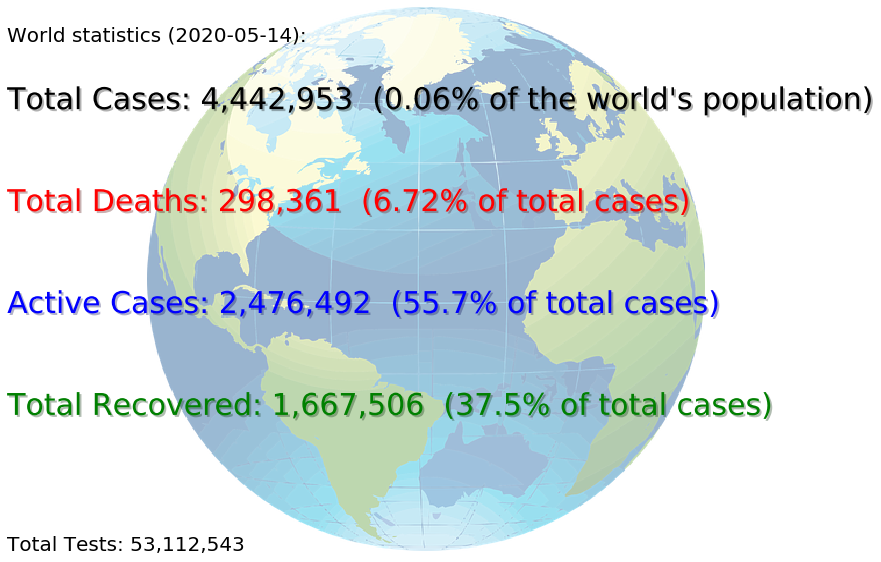

In [17]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
im = plt.imread('https://i.pinimg.com/originals/2e/16/38/2e1638b1ceacd2474452dad58ad2227b.png')
plt.imshow(im, extent=[0.2,1,0.2,1], zorder=0, aspect='auto', alpha=0.4)
plt.text(0, 0.95,f'World statistics ({datetime.date.today()}):', fontsize=20)
plt.text(0, 0.85,f'Total Cases: {df["TotalCases"].sum():,}  '\
         f'({round(df["TotalCases"].sum()/df["Population (2020)"].sum()*100,2)}% of the world\'s population)',
         color='black', fontsize=30,path_effects=[path_effects.withSimplePatchShadow()]);
plt.text(0, 0.7,f'Total Deaths: {int(df["TotalDeaths"].sum()):,}  '\
         f'({round(df["TotalDeaths"].sum()/df["TotalCases"].sum()*100,2)}% of total cases)',color='r', fontsize=30,
        path_effects=[path_effects.withSimplePatchShadow()]);
plt.text(0, 0.55,f'Active Cases: {df["ActiveCases"].sum():,}  '\
         f'({round(df["ActiveCases"].sum()/df["TotalCases"].sum()*100,1)}% of total cases)',color='b', fontsize=30,
        path_effects=[path_effects.withSimplePatchShadow()]);
plt.text(0, 0.4,f'Total Recovered: {int(df["TotalRecovered"].sum()):,}  '\
         f'({round(df["TotalRecovered"].sum()/df["TotalCases"].sum()*100,1)}% of total cases)',color='g', fontsize=30,
        path_effects=[path_effects.withSimplePatchShadow()]);
plt.text(0, 0.2,f'Total Tests: {int(df["TotalTests"].sum()):,}',color='black', fontsize=20);
plt.axis('off');

<br>
<br>
<br>
<br>
<br>




### Worldwide Covid19 choropleth map 

In [18]:
world_map = folium.Map(location=[10,0], tiles="cartodbpositron", zoom_start=2, max_zoom=6, min_zoom=2)
with open('world-countries.json') as f:
    world_geo = json.load(f)

countries_dict =({'United States' : 'United States of America', 'UAE': 'United Arab Emirates',
                 'Palestine':'West Bank'})

data = np.log2(df[['Tot Cases_1M']]).reset_index()
data.Country.replace(countries_dict, inplace=True)

choropleth = folium.Choropleth(
    geo_data=world_geo,
    name='choropleth',
    data=data,
    columns=['Country', 'Tot Cases_1M'],
    key_on='feature.properties.name',
    fill_color='OrRd',
    fill_opacity=0.9,
    line_opacity=0.2,
    nan_fill_color='#fef0d9',
    nan_fill_opacity=0.2,
    legend_name='Tot Cases_1M log scale',
    highlight=True,
    line_color='black'
).add_to(world_map)

style_function = "font-size: 15px; font-weight: bold"

world_map

### Looking at the TotalCases statistics,<br> We can see that most of the cases comes from a small number of countries.

count        211.0
mean       21057.0
std       106202.0
min            1.0
25%          108.0
50%          815.0
75%         6382.0
max      1430348.0
Name: TotalCases, dtype: float64


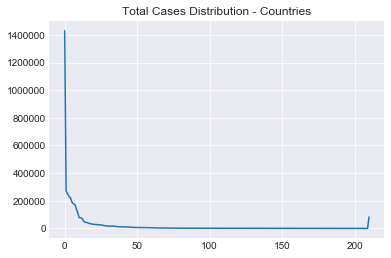

In [19]:
# We can see that most of the data comes from a small number of countries.
plt.style.use('seaborn-darkgrid')
print(df['TotalCases'].describe().round())
df.reset_index()['TotalCases'].plot(title='Total Cases Distribution - Countries');

### Let's look at the current global view with a 100% stacked bar charts showing each stack component's relative contribution (in percents) to the whole bar and the whole entity.
* Filtered out countries with fewer than 5000 total cases.
* United Kingdom and Netherlands Total Recovered data is missing.  

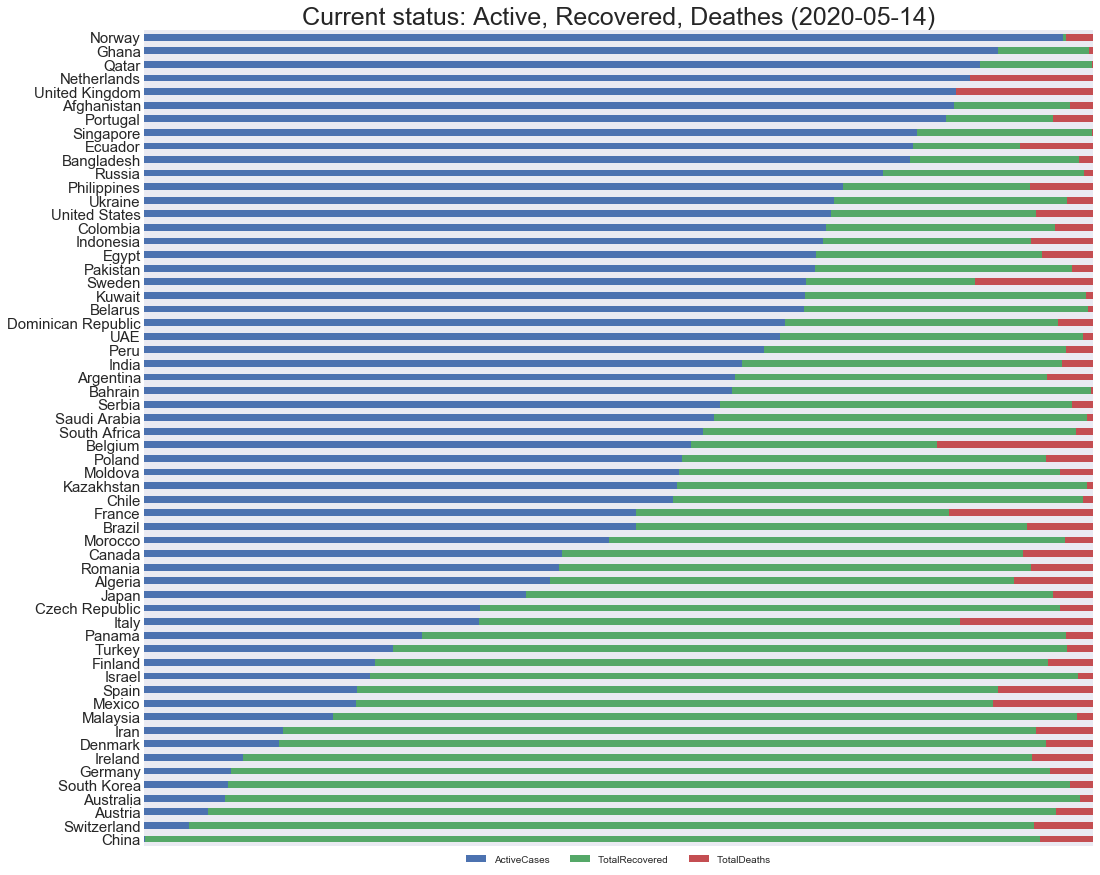

In [20]:
plot_stacked_pct()

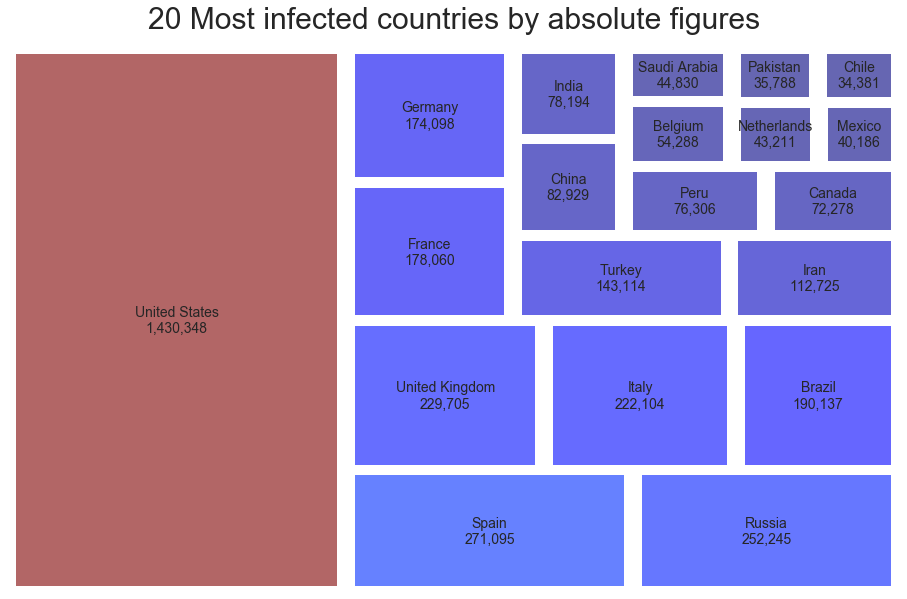

In [21]:
worst_countries_cases = df[['TotalCases']].sort_values(by='TotalCases',ascending=False).head(20)
worst_countries_cases['Label'] = worst_countries_cases.index + "\n" + worst_countries_cases['TotalCases']\
.apply(lambda x : "{:,}".format(x))

# worst_countries_cases = df[['TotalCases']].sort_values(by='TotalCases',ascending=False).head(int(0.1*len(df)))
plt.figure(figsize=(16,10))
plt.axis('off')
mini = min(worst_countries_cases['TotalCases'])
maxi = max(worst_countries_cases['TotalCases'])
# Finding Colors for each tile
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
cmap = matplotlib.cm.jet
colors = [cmap(norm(value)) for value in worst_countries_cases['TotalCases']]
squarify.plot(worst_countries_cases['TotalCases'], label=worst_countries_cases['Label'],color=colors, alpha=0.6,pad=True,
              text_kwargs={'fontsize':14});
plt.title('20 Most infected countries by absolute figures', pad=20,fontsize=30);


In [22]:
print(f"** Those 20 Most infected countries accounts for "\
      f"{round(worst_countries_cases['TotalCases'].sum()/df['TotalCases'].sum()*100,1)}% of cases worldwide.")

** Those 20 Most infected countries accounts for 84.8% of cases worldwide.


Now, Let's look at the number of deaths divided by the number of confirmed cases


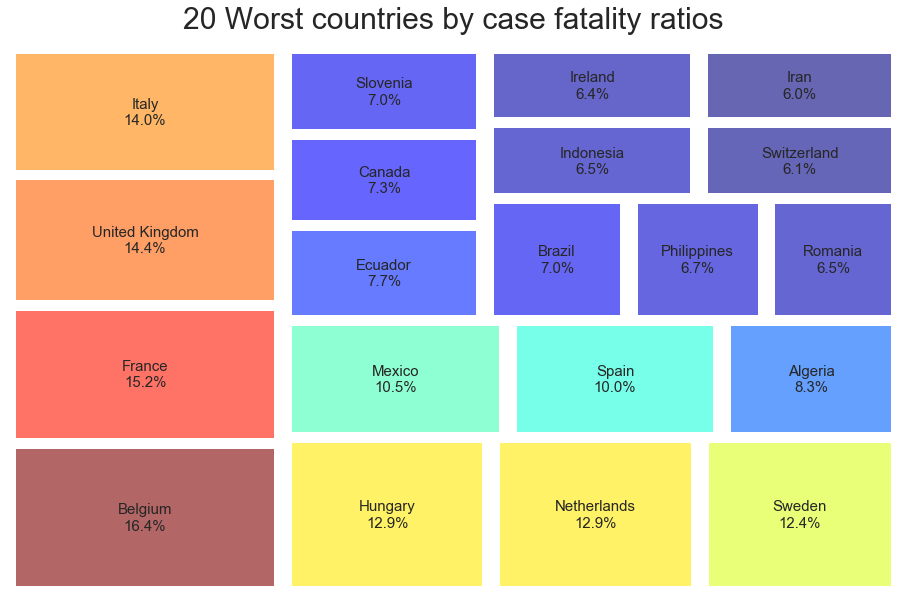

In [23]:
worst_mortality_rate = df[df['TotalCases'] > 1000][['Deaths/Cases']].sort_values(by='Deaths/Cases',
                       ascending=False).head(20).round(3)
worst_mortality_rate['Label'] = worst_mortality_rate.index + "\n" + worst_mortality_rate['Deaths/Cases']\
.apply(lambda x : "{:.1%}".format(x))
# worst_countries_cases = df[['TotalCases']].sort_values(by='TotalCases',ascending=False).head(int(0.1*len(df)))
plt.figure(figsize=(16,10))
plt.axis('off')
mini = min(worst_mortality_rate['Deaths/Cases'])
maxi = max(worst_mortality_rate['Deaths/Cases'])
# Finding Colors for each tile
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
cmap = matplotlib.cm.jet
colors = [cmap(norm(value)) for value in worst_mortality_rate['Deaths/Cases']]
squarify.plot(worst_mortality_rate['Deaths/Cases'], label=worst_mortality_rate['Label'],color=colors, alpha=0.6,pad=True,
              text_kwargs={'fontsize':15});
plt.title('20 Worst countries by case fatality ratios', pad=20,fontsize=30);
print("Now, Let's look at the number of deaths divided by the number of confirmed cases")

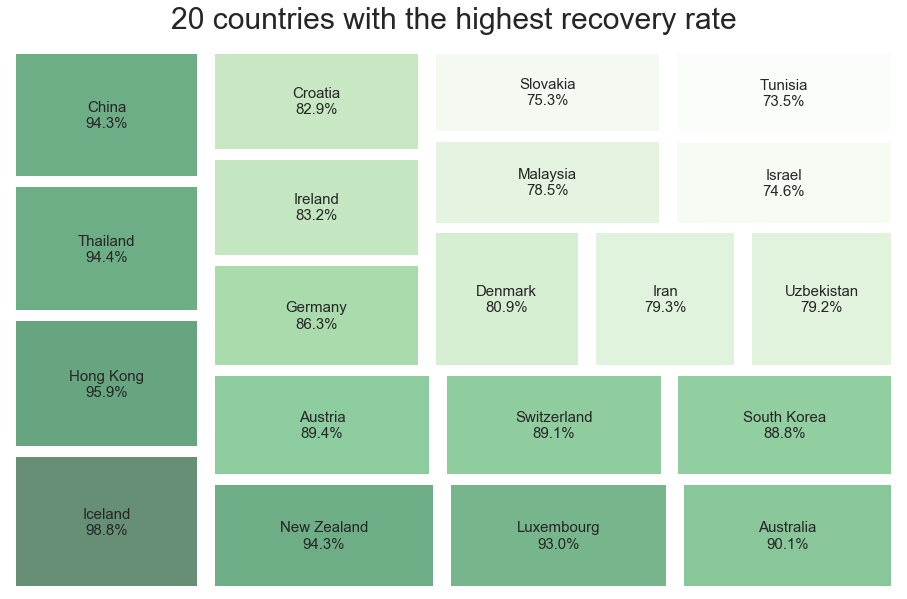

In [24]:
recovery_rate = df[df['TotalCases'] > 1000][['Recovered/Cases']].sort_values(by='Recovered/Cases',
                ascending=False).head(20).round(3)
recovery_rate['Label'] = recovery_rate.index + "\n" + recovery_rate['Recovered/Cases']\
.apply(lambda x : "{:.1%}".format(x))
# worst_countries_cases = df[['TotalCases']].sort_values(by='TotalCases',ascending=False).head(int(0.1*len(df)))
plt.figure(figsize=(16,10))
plt.axis('off')
mini = min(recovery_rate['Recovered/Cases'])
maxi = max(recovery_rate['Recovered/Cases'])
# Finding Colors for each tile
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
cmap = matplotlib.cm.Greens
colors = [cmap(norm(value)) for value in recovery_rate['Recovered/Cases']]
squarify.plot(recovery_rate['Recovered/Cases'], label=recovery_rate['Label'],color=colors, alpha=0.6,pad=True,
              text_kwargs={'fontsize':15});
plt.title('20 countries with the highest recovery rate', pad=20,fontsize=30);


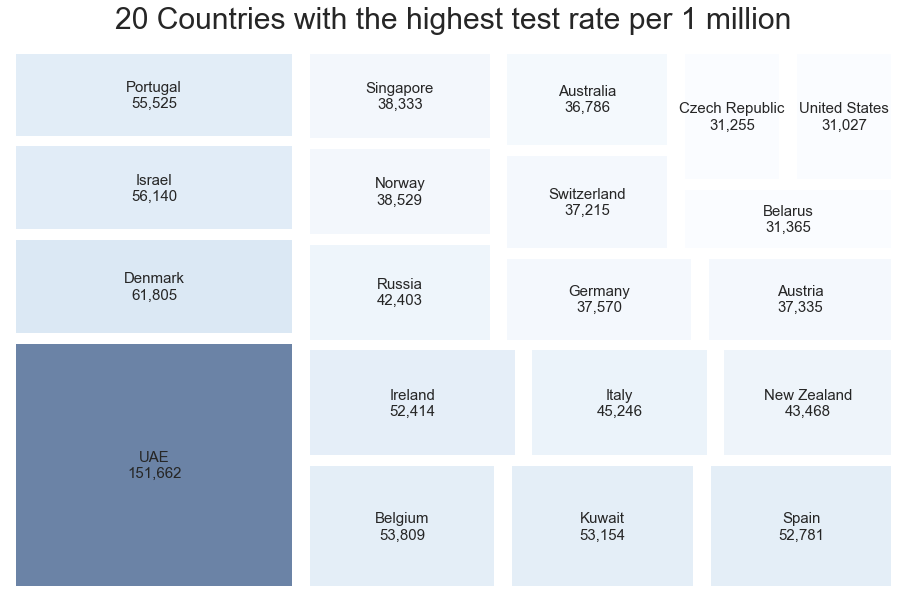

In [25]:
tested_rate = df[(df['TotalCases'] > 100) & (df['Population (2020)']>4_000_000)][['Tests/ 1M pop']]\
              .sort_values(by='Tests/ 1M pop', ascending=False).head(20)
tested_rate['Tests/ 1M pop'] = tested_rate['Tests/ 1M pop'].astype(int)
tested_rate['Label'] = tested_rate.index + "\n" + tested_rate['Tests/ 1M pop']\
                       .apply(lambda x : "{:,}".format(x))
# worst_countries_cases = df[['TotalCases']].sort_values(by='TotalCases',ascending=False).head(int(0.1*len(df)))
plt.figure(figsize=(16,10))
plt.axis('off')
mini = min(tested_rate['Tests/ 1M pop'])
maxi = max(tested_rate['Tests/ 1M pop'])
# Finding Colors for each tile
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
cmap = matplotlib.cm.Blues
colors = [cmap(norm(value)) for value in tested_rate['Tests/ 1M pop']]
squarify.plot(tested_rate['Tests/ 1M pop'], label=tested_rate['Label'],color=colors, alpha=0.6,pad=True,
              text_kwargs={'fontsize':15});
plt.title('20 Countries with the highest test rate per 1 million',fontsize=30, pad=20);

#### Main statistics for the numeric columns

In [26]:
# Look at the main statistics for the numeric columns
df.describe().T.round(1)

count        mean          std     min       25%  \
TotalCases         211.0     21056.6     106201.7     1.0     108.5   
NewCases           211.0        91.0        707.9     0.0       0.0   
TotalDeaths        211.0      1414.0       7204.0     0.0       2.0   
TotalRecovered     211.0      7902.9      30495.6     0.0      34.5   
ActiveCases        211.0     11736.9      74437.1     0.0      27.0   
Serious            211.0       217.6       1302.3     0.0       0.0   
Tot Cases_1M       211.0       984.4       1958.4     0.5      53.0   
Deaths/1M pop      211.0        47.8        136.3     0.0       0.4   
TotalTests         211.0    251718.2     917378.6     0.0    1352.0   
Tests/ 1M pop      211.0     17255.6      29499.2     0.0     608.0   
Population (2020)  211.0  36741955.7  142198752.2  3480.0  882456.5   
Density (P/Km²)    211.0       502.5       2455.9     0.0      37.0   
Fert. Rate         211.0         2.4          1.5     0.0       1.6   
MedAg              211.0        27.6         12.8     0.0      19.5   
Urban Pop %        211.0        57.6         25.9     0.0      39.0   
Cases/Test         211.0         inf          NaN     0.0       0.0   
Deaths/Cases       211.0         0.0          0.0     0.0       0.0   
Recovered/Cases    211.0         0.5          0.3     0.0       0.3   

                         50%         75%           max  
TotalCases             815.0      6382.5  1.430348e+06  
NewCases                 0.0         0.0  9.974000e+03  
TotalDeaths             17.0       150.5  8.519700e+04  
TotalRecovered         310.0      2372.5  3.102590e+05  
ActiveCases            280.0      2644.0  1.034892e+06  
Serious                  2.0        22.5  1.634900e+04  
Tot Cases_1M           214.0      1164.5  1.895000e+04  
Deaths/1M pop            4.0        26.5  1.208000e+03  
TotalTests           17589.0    160527.5  1.027000e+07  
Tests/ 1M pop         4247.0     19157.0  1.767800e+05  
Population (2020)  6948445.0  25939079.0  1.439324e+09  
Density (P/Km²)         94.0       237.5  2.633700e+04  
Fert. Rate               2.1         3.0  7.000000e+00  
MedAg                   29.0        38.0  4.800000e+01  
Urban Pop %             59.0        79.0  1.000000e+02  
Cases/Test               0.1         0.2           inf  
Deaths/Cases             0.0         0.1  3.000000e-01  
Recovered/Cases          0.5         0.8  1.000000e+00

#### We can see that most of the data comes from a small number of countries.

In [27]:
df['World%TotalCases'] = np.round(df['TotalCases'] / df['TotalCases'].sum() ,3)
print(f'Worldwide Coronavirus Cases: {df.TotalCases.sum():,}')
df.sort_values(by='TotalCases', ascending=False)[[ 'TotalCases','World%TotalCases']].head(5)\
.style.format({'TotalCases':'{:,.0f}','World%TotalCases':'{:,.1%}'}).background_gradient(cmap='Reds')\
.set_caption('Worst hit countries')\
.background_gradient(cmap='binary',subset=["TotalCases"])\
.background_gradient(cmap='Oranges',subset=["World%TotalCases"])

Worldwide Coronavirus Cases: 4,442,953


### Five countries have almost 55% of all cases worldwide.

<!-- We will drop countries with less than 100 positive cases as they are less relevant to our overall statistics. -->

## Global spread of COVID-19 
#### (Countries with a population of over 1,000,000)

In [28]:
worst_c = df[df['Population (2020)']>1_000_000].sort_values('Deaths/1M pop',ascending=False)
worst_c = worst_c[['Tot Cases_1M', 'Deaths/1M pop']].head(round(0.1 * len(worst_c)))
worst_c.style.format("{:,.0f}").background_gradient(cmap='Reds').set_caption('Worst hit countries')

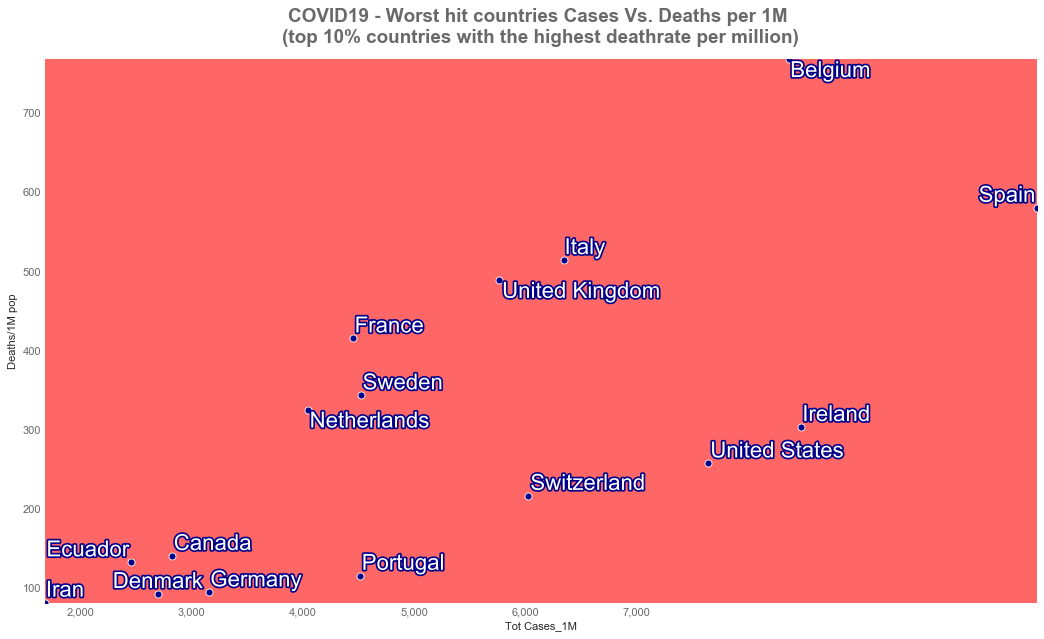

In [29]:
worst_countries()

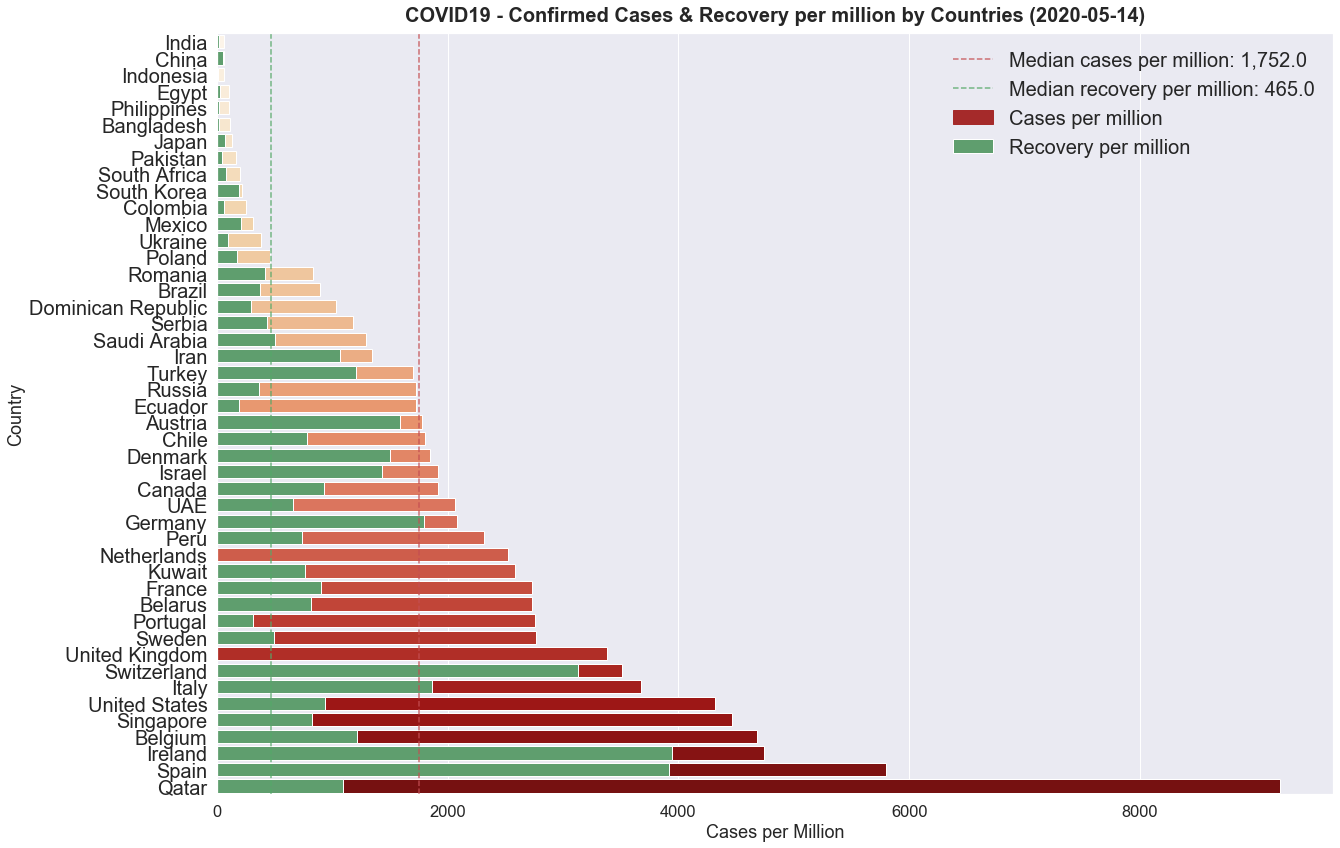

In [30]:
countries_cases_recovery()

In [31]:
df_ir = df[(df['Tests/ 1M pop'] > 5000) & (df['TotalCases']>5000)].reset_index()
df_ir['recoverd\cases'] = df_ir['TotalRecovered'] / (df_ir['TotalCases'] - df_ir['TotalDeaths'])
df_ir['Cases_tests_recoverd_retio'] = df_ir['recoverd\cases'] * df_ir['Cases/Test']
df_ir = df_ir.sort_values(by='Cases/Test')
# df_ir[['Country','Population (2020)','Tests/ 1M pop','Cases/Test']].sort_values(by='Tests/ 1M pop')

In [32]:
df = df[df['TotalCases'] >1000]

In [33]:
# Correlations
# df.corr()

## <u>Correlations:</u>

### In order to try to find correlations that could be more statistically valid,<br>I have filtered out countries with fewer than 1000 total cases.

Number of countries: 97


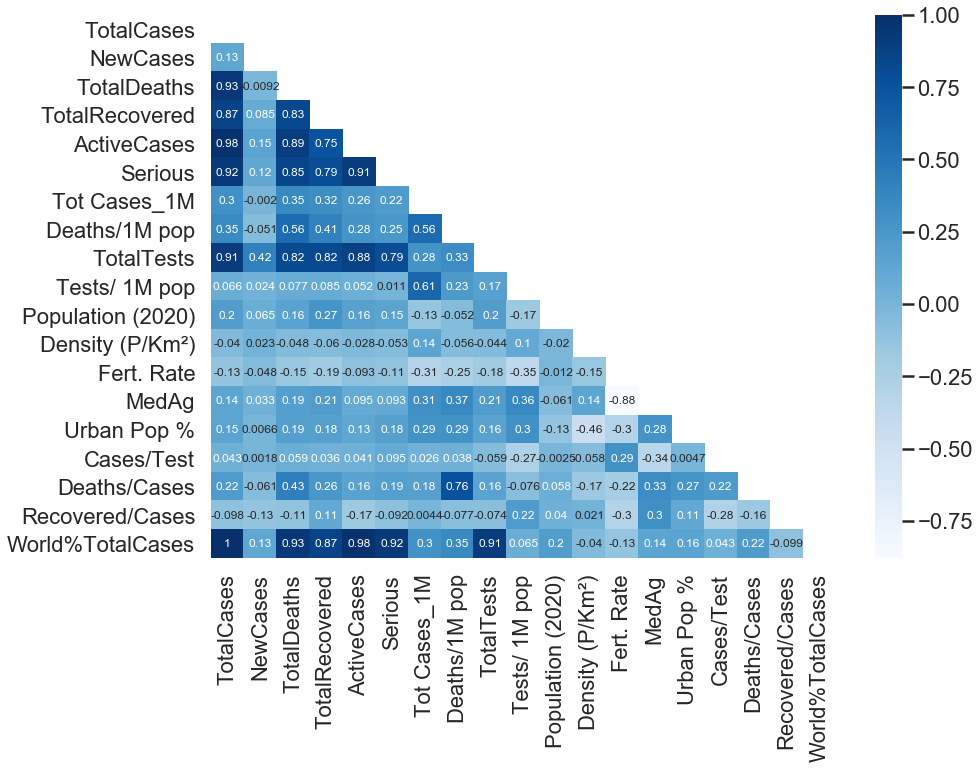

In [34]:
# In order to try to find correlations that could be more statistically valid,
# I have filled in total cases to more than 10,000.

print(f"Number of countries: {len(df)}")
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(corr, mask=mask, cmap='Blues', annot=True,annot_kws={"size":12})
    sns.set(font_scale=1.5);


The majority of the high correlations listed above derive from the dependent variables and their ratios,<br>
Let's look at the less clear relationships:

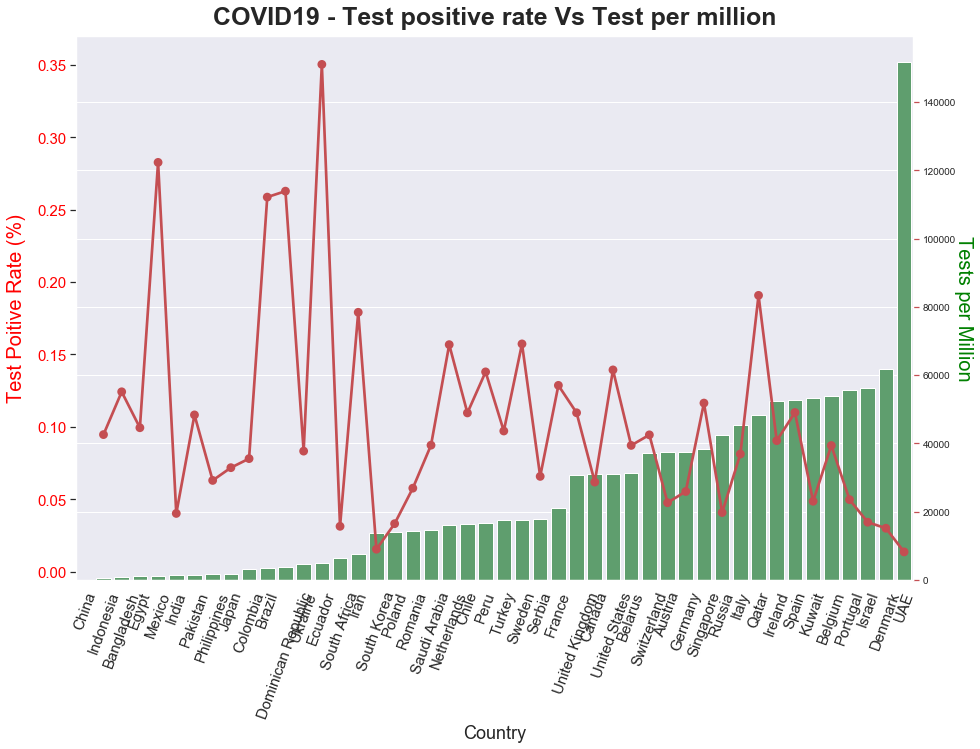

In [35]:
countries_tpr_tr()

In [36]:
print(f"The correlation between TPR (Test Positive Rate) and number of test's per million is "\
      f"{round(df[df['Tests/ 1M pop']>0]['Tests/ 1M pop'].corr(df[df['Tests/ 1M pop']>0]['Cases/Test']),2)},\nwhich means "\
      f"the TPR goes down as more people are tested.")


The correlation between TPR (Test Positive Rate) and number of test's per million is -0.27,
which means the TPR goes down as more people are tested.


<b>Urban percentages</b> are the number of persons residing in an area identified as 'urban' per 100 total population,<br>
let's see if thier is any correlation between that percentage and the ratio of deaths / cases.

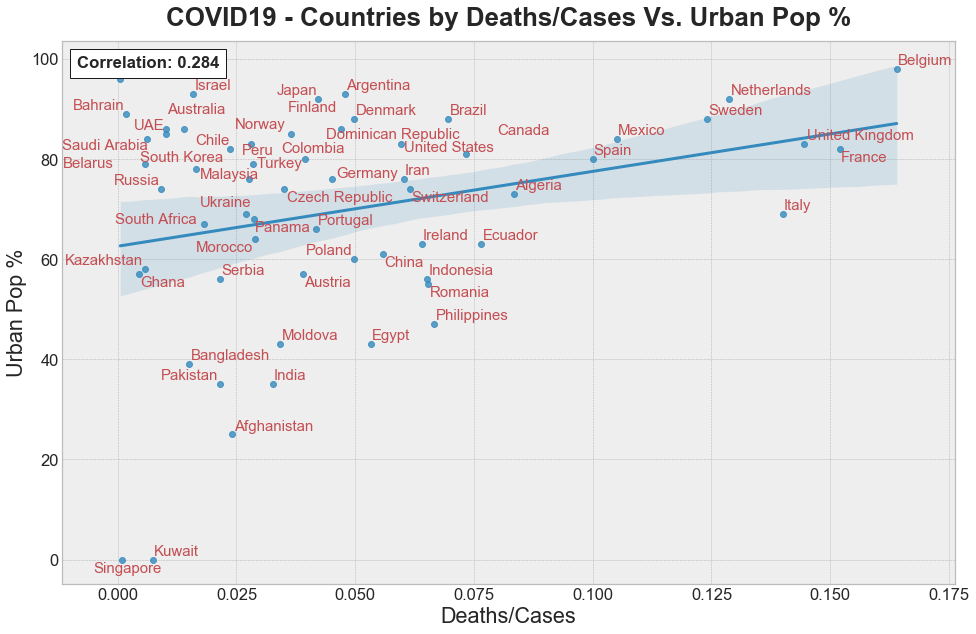

In [37]:
pair_corr_plot(df,tc_threshold=5000, x='Deaths/Cases',y='Urban Pop %')

### Explore the median age and death rate correlation, filter out countries with fewer than 1,000 deaths.

In [38]:
# Median age correlation, with countries that has more than 1,000 deaths.
df_cor_age = df[df['TotalDeaths']>1000][['Deaths/Cases', 'MedAg']].sort_values('MedAg', ascending=False)
df_cor_age = df_cor_age[df_cor_age['MedAg'] > 10]
print(df_cor_age.corr())
df_cor_age.reset_index()

              Deaths/Cases     MedAg
Deaths/Cases      1.000000  0.348096
MedAg             0.348096  1.000000


Country  Deaths/Cases  MedAg
0            Italy      0.140052     47
1          Germany      0.045153     46
2         Portugal      0.041767     46
3            Spain      0.099980     45
4      Netherlands      0.128717     43
5          Romania      0.065367     43
6      Switzerland      0.061487     43
7           France      0.152050     42
8          Belgium      0.163996     42
9           Canada      0.073356     41
10          Sweden      0.123974     41
11          Russia      0.009138     40
12  United Kingdom      0.144472     40
13         Ireland      0.063972     38
14   United States      0.059564     38
15           China      0.055867     38
16          Brazil      0.069634     33
17            Iran      0.060173     32
18          Turkey      0.027614     32
19            Peru      0.028425     31
20       Indonesia      0.065163     30
21          Mexico      0.105012     29
22         Ecuador      0.076560     28
23           India      0.032624     28

### Cheak death rate at top and bottom quantiles (deaths/total cases)
So let's take countries with a median age > 0.75 quantile of median age, <br>
and countries with a median age < 0.25 quantile of median age to investigate the mortality rates in those two categories.

In [39]:
# Cheak death rate at top and bottom quantiles (deaths/total cases)
df_med = df[df['MedAg'] !=0].copy()
df_topQ_Age = df_med[df_med['MedAg'] > df_med['MedAg'].quantile(0.75)]
df_bottomQ_Age = df_med[df_med['MedAg'] < df_med['MedAg'].quantile(0.25)]

death_rate_top10q_med_age = df_topQ_Age['TotalDeaths'].sum()/df_topQ_Age['TotalCases'].sum() 
death_rate_bottom10q_med_age = df_bottomQ_Age['TotalDeaths'].sum()/df_bottomQ_Age['TotalCases'].sum() 

print(f"Death rate Top 25% median age countries: {round(death_rate_top10q_med_age *100,1)}%")
print(f"Death rate Bottom 25% median age countries: {round(death_rate_bottom10q_med_age *100,1)}%")

Death rate Top 25% median age countries: 9.2%
Death rate Bottom 25% median age countries: 3.2%


### Let's look at the correlation for all countries with more than 5,000 total cases.

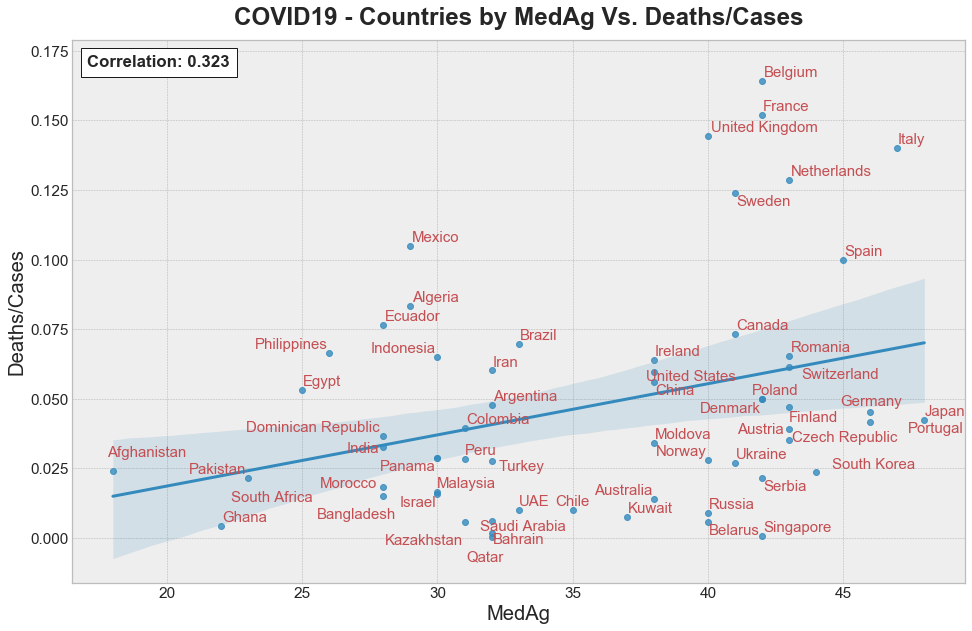

In [40]:
pair_corr_plot(df, tc_threshold=5000)

### And now the correlation for all countries with more than 20,000 total cases.

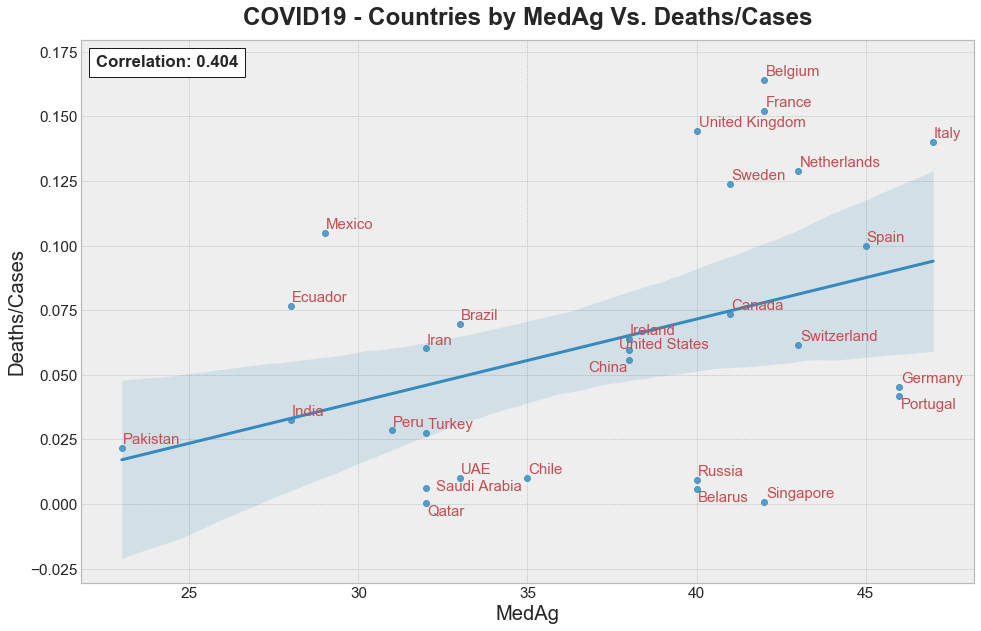

In [41]:
pair_corr_plot(df, tc_threshold=20000)

In [42]:
df.head()

TotalCases  NewCases  TotalDeaths  TotalRecovered  \
Country                                                             
United States      1430348       0.0      85197.0        310259.0   
Spain               271095       0.0      27104.0        183227.0   
Russia              252245    9974.0       2305.0         53530.0   
United Kingdom      229705       0.0      33186.0             0.0   
Italy               222104       0.0      31106.0        112541.0   

                ActiveCases  Serious  Tot Cases_1M  Deaths/1M pop  TotalTests  \
Country                                                                         
United States       1034892  16349.0        4321.0          257.0  10269996.0   
Spain                 60764   1534.0        5798.0          580.0   2467761.0   
Russia               196410   2300.0        1728.0           16.0   6188102.0   
United Kingdom       196175   1559.0        3384.0          489.0   2094209.0   
Italy                 78457    893.0        3673.0          514.0   2735628.0   

                Tests/ 1M pop  Population (2020)  Density (P/Km²)  Fert. Rate  \
Country                                                                         
United States         31027.0          331002651               36         1.8   
Spain                 52781.0           46754778               94         1.3   
Russia                42403.0          145934462                9         1.8   
United Kingdom        30849.0           67886011              281         1.8   
Italy                 45246.0           60461826              206         1.3   

                MedAg  Urban Pop %  Cases/Test  Deaths/Cases  Recovered/Cases  \
Country                                                                         
United States      38         83.0    0.139274      0.059564         0.216912   
Spain              45         80.0    0.109855      0.099980         0.675877   
Russia             40         74.0    0.040763      0.009138         0.212214   
United Kingdom     40         83.0    0.109686      0.144472         0.000000   
Italy              47         69.0    0.081189      0.140052         0.506704   

                World%TotalCases  
Country                           
United States              0.322  
Spain                      0.061  
Russia                     0.057  
United Kingdom             0.052  
Italy                      0.050

We can also see the correlation between fertility rate and median age.<br> 
This process mostly in developed countries results in a rise in the median age of the population,<br>
when fertility rates decline while life expectancy remains constant or improves at the older ages.

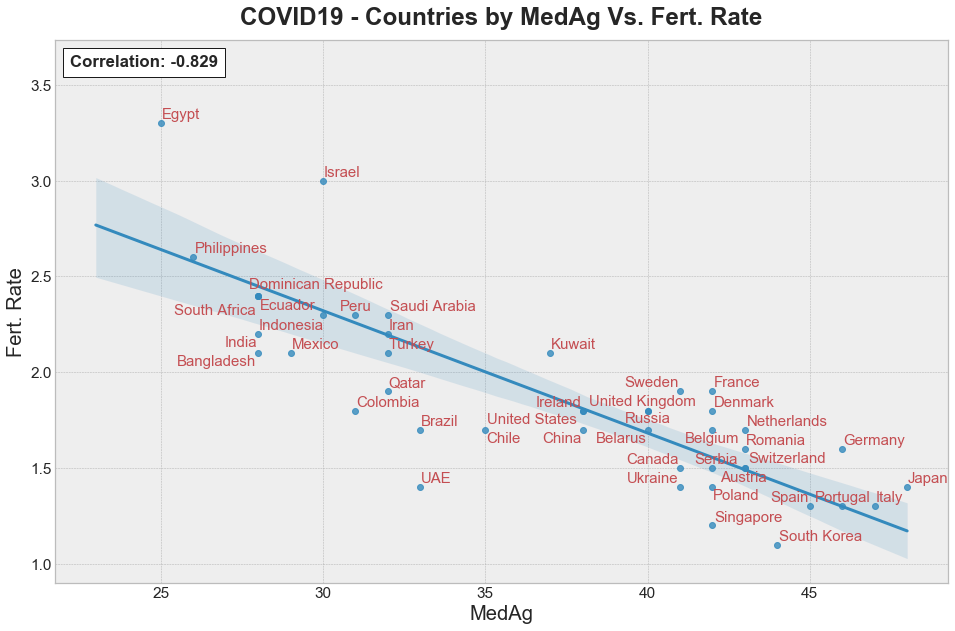

In [43]:
pair_corr_plot(df,y='Fert. Rate', x='MedAg')

In [44]:
# df[df['TotalCases']>10000].corr()

In [45]:
# df[df['TotalCases'] > 50000][['Population (2020)','MedAg']].corr()

To further inspect the relationship between age and death from coronarvirus, we need more than median age data,<br>
so I have scrapped a list of countries and thier dependency ratios (from Wikipedia All data is for the year 2020. Source is the CIA World Factbook.),<br> merged them with our data set,to inspect the link between the elderly dependence and the Death / Case ratios.<br>
<b>The elderly dependency ratio</b> is the ratio of the elderly population (ages 65+) per 100 people of working age (ages 15-64)<br><br>


![Dependency ratio](https://wikimedia.org/api/rest_v1/media/math/render/svg/7ffdce78a4e6395a8a36f5bc5df82a5726edb354)


In [46]:
dep = pd.read_html('https://en.wikipedia.org/wiki/List_of_countries_by_dependency_ratio')[0]

In [47]:
df_dep = df.merge(dep,left_index=True, right_on='Country')

In [48]:
df_dep[['Tot Cases_1M', 'Deaths/Cases','elderly dependency ratio']].corr()

Tot Cases_1M  Deaths/Cases  elderly dependency ratio
Tot Cases_1M                  1.000000      0.200209                  0.221787
Deaths/Cases                  0.200209      1.000000                  0.449864
elderly dependency ratio      0.221787      0.449864                  1.000000

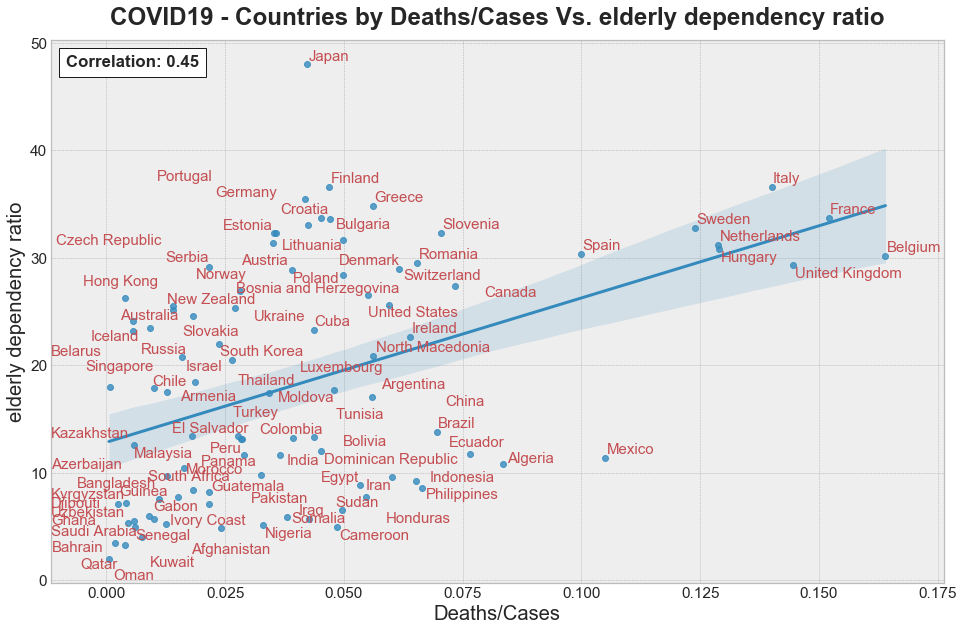

In [49]:
pair_corr_plot(df_dep,tc_threshold=1000, x='Deaths/Cases',y='elderly dependency ratio')

<b>As we did earlier,</b> let's cheek again the death rate at top and bottom quantiles (deaths/total cases)<br>
So we'll take countries with <b>elderly dependency ratio > 0.75</b> quantile,<br>
and countries with <b>elderly dependency ratio < 0.25 </b> quantile, to inspect mortality rates in these two classes:

In [50]:
# Cheak death rate at top and bottom quantiles (deaths/total cases)
df_topQ_edr = df_dep[df_dep['elderly dependency ratio'] > df_dep['elderly dependency ratio'].quantile(0.75)]
df_bottomQ_edr = df_dep[df_dep['elderly dependency ratio'] < df_dep['elderly dependency ratio'].quantile(0.25)]

death_rate_top10q_edr = df_topQ_edr['TotalDeaths'].sum()/df_topQ_edr['TotalCases'].sum() 
death_rate_bottom10q_edr = df_bottomQ_edr['TotalDeaths'].sum()/df_bottomQ_edr['TotalCases'].sum() 

print(df_dep['elderly dependency ratio'].describe())
print(f"Death rate for countries in the Highest 25% elderly dependency ratio: {round(death_rate_top10q_edr *100,1)}%")
print(f"Death rate for countries in the Lowest 25% elderly dependency ratio: {round(death_rate_bottom10q_edr *100,1)}%")

count    95.000000
mean     18.456842
std      10.836008
min       2.000000
25%       8.500000
50%      17.500000
75%      28.650000
max      48.000000
Name: elderly dependency ratio, dtype: float64
Death rate for countries in the Highest 25% elderly dependency ratio: 11.2%
Death rate for countries in the Lowest 25% elderly dependency ratio: 1.3%


<span style="background-color:Yellow"><b>Now we can see the connection between age distribution and the ratio of deaths/cases more clearly.<br>
Covid-19 mortality rates are higher in those countries where we already have an ageing population,<br> of course their are other variables that can affect the number of cases and fertility rates such as, lock-downs, social distance,<br> climte, advanced health care system .. etc ..that require further exploring and behind the scope of our data for this eda.</b></span>

<br>
<br>
<br>
<br>
<br>


### Let's analyze and compare the OECD countries.

![covid image](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQPZ2DW5AS0fWlYeksl2N5zivVbjQouqeQqx5Z-uEE8YwwL-ipV&usqp=CAU)


In [51]:
pd.set_option('display.max_rows', 500)
df_oecd = df[df.index.isin(oecd_countries)]
df_oecd['% Deaths'] = (df_oecd['TotalDeaths'] / df_oecd['TotalCases']).round(3)
df_oecd['% Recovered'] = (df_oecd['TotalRecovered'] / df_oecd['TotalCases']).round(3)
df_oecd['% Active'] = (df_oecd['ActiveCases'] / df_oecd['TotalCases']).round(3)
df_oecd[['TotalCases','TotalDeaths','ActiveCases','TotalRecovered','% Deaths', '% Active','% Recovered']].style\
.format({'TotalCases':'{:,.0f}', 'TotalDeaths':'{:,.0f}','ActiveCases':'{:,.0f}','TotalRecovered':'{:,.0f}',
         '% Deaths':'{:.01%}','% Active':'{:.01%}','% Recovered':'{:.01%}'})\
.background_gradient(cmap='Blues',subset=["TotalCases"])\
.background_gradient(cmap='Reds',subset=["TotalDeaths"])\
.background_gradient(cmap='OrRd',subset=["% Deaths"])\
.background_gradient(cmap='Greens',subset=["TotalRecovered"])\
.background_gradient(cmap='Greens',subset=["% Recovered"])\
.background_gradient(cmap='OrRd',subset=["ActiveCases"])\
.background_gradient(cmap='PuBu',subset=["% Active"])\
.set_caption('OECD countries')

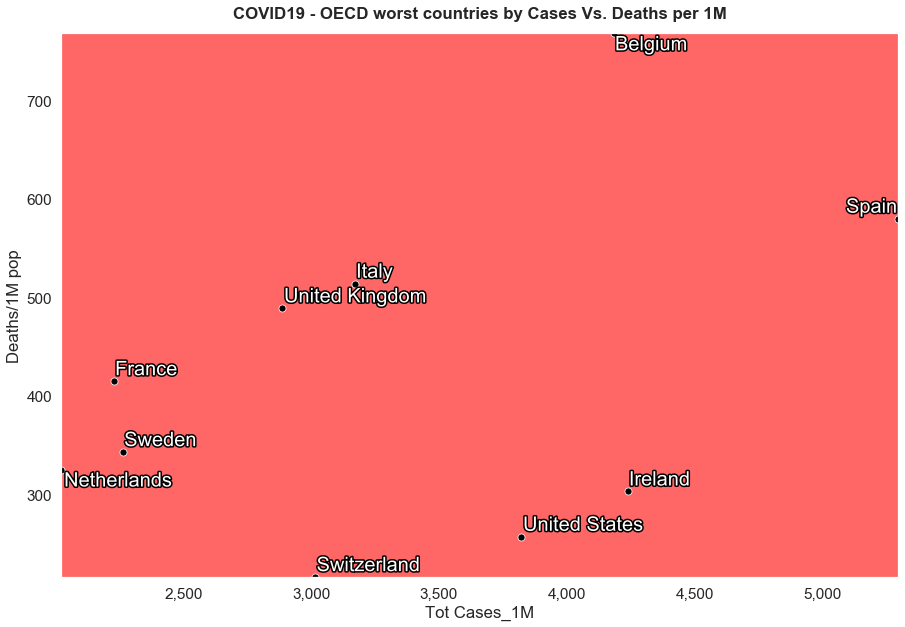

In [52]:
import matplotlib.patheffects as path_effects

plt.style.use('seaborn-deep')

df_oecd_chart = df[df.index.isin(oecd_countries)].reset_index()
median_ir = df_oecd_chart['Deaths/1M pop'].median()
df_oecd_chart = df_oecd_chart.sort_values('Deaths/1M pop', ascending=False).head(10)
fig, ax = plt.subplots(figsize = (15, 10))
sns.scatterplot(x='Tot Cases_1M', y='Deaths/1M pop', data=df_oecd_chart, s=50, color='black');
text = [plt.text(x, y, z, color='w', size=20,path_effects=[path_effects.Stroke(linewidth=3,
        foreground='black'), path_effects.Normal()]) for x, y, z in zip(df_oecd_chart['Tot Cases_1M'],
        df_oecd_chart['Deaths/1M pop'],df_oecd_chart['Country'])]
plt.title(f'COVID19 - OECD worst countries by Cases Vs. Deaths per 1M',pad=15,weight = 'semibold')
# ax.set(xlim=(0,0.35));
# plt.axvspan(0, median_ir, facecolor='g', alpha=0.5)
# plt.axvspan(median_ir, 0.35, facecolor='r', alpha=0.5)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
plt.margins(x=0,y=0);plt.grid(b=None);
ax.patch.set_facecolor('red');ax.patch.set_alpha(0.6);
adjust_text(text);
path_effects=[path_effects.withSimplePatchShadow()]

In [53]:
df_oecd.reset_index(inplace=True)

fig = go.Figure(data=[
    go.Pie(labels=df_oecd['Country'], 
           values=df_oecd['TotalCases'], 
           hole=.45,
           textinfo='label+percent'
          )
])

fig.update_layout(
    height=700,
    width=700,
    title_text="Positive Cases Percentage - OECD Countries",
    annotations=[
        dict(text='Positive<br>Cases', showarrow=False),
    ]
)
fig.update_traces(textposition='inside')
fig.show()

In [54]:
print(f"** OECD countries accounts for "\
      f"{round(df_oecd['TotalCases'].sum()/df['TotalCases'].sum()*100,1)}% of cases worldwide.")

** OECD countries accounts for 71.4% of cases worldwide.


<br>
<br>
<br>
<br>
<br>

## United States

![US states](https://cdnuploads.aa.com.tr/uploads/Contents/2020/03/31/thumbs_b_c_f0c9e70408e03dcbd2c231d82228c08b.jpg?v=210121)


In [55]:
# US positive
us_p = usa_covid19.groupby('state')['positive'].first().sum()

# US test positive rate
us_pr =us_p /(usa_covid19.groupby('state')['totalTestResults'].first().sum())

# US recovered
us_r=usa_covid19.groupby('state')['recovered'].first().sum()

# US recovered percentage
us_rp = us_r / (usa_covid19.groupby('state')['positive'].first().sum())

# US deaths
us_d = usa_covid19.groupby('state')['death'].first().sum()

# US deaths percentage
us_dp = us_d / us_p

# US total tests
us_t = usa_covid19.groupby('state')['totalTestResults'].first().sum()



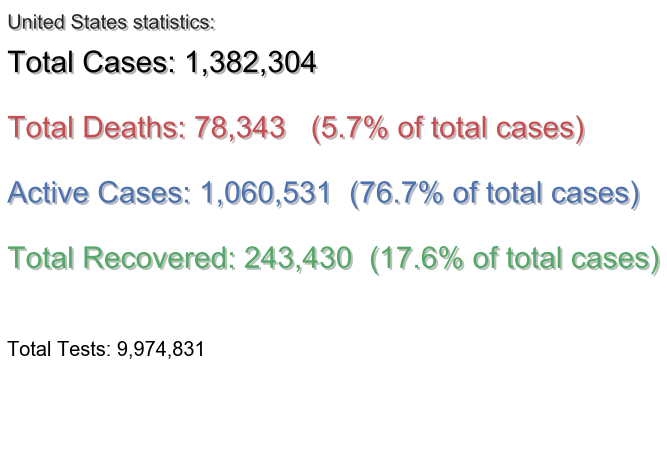

In [56]:
import matplotlib.patheffects as path_effects

fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,1,1)
# plt.imshow(im_usa, extent=[0.6,1,0.2,1], zorder=0, aspect='auto', alpha=0.7)
plt.text(0, 0.95,'United States statistics:', fontsize=20,path_effects=[path_effects.withSimplePatchShadow()])
plt.text(0, 0.85,f"Total Cases: {int(us_p):,}", color='black', fontsize=30,path_effects=[path_effects.withSimplePatchShadow()]);
plt.text(0, 0.7,f"Total Deaths: {int(us_d):,}   ({round(us_dp*100,1)}% of total cases)",color='r', fontsize=30,
        path_effects=[path_effects.withSimplePatchShadow()]);
plt.text(0, 0.55,f'Active Cases: {int(us_p-(us_r + us_d)):,}  ({round((us_p-(us_r + us_d))/us_p*100,1)}% of total cases)',
         color='b', fontsize=30,path_effects=[path_effects.withSimplePatchShadow()]);
plt.text(0, 0.4,f'Total Recovered: {int(us_r):,}  ({round(us_r/us_p*100,1)}% of total cases)',color='g', fontsize=30,
        path_effects=[path_effects.withSimplePatchShadow()]);
plt.text(0, 0.2,f'Total Tests: {int(us_t):,}',color='black', fontsize=20);
plt.axis('off');


In [57]:
# States symbols
# usa_covid19['state'].unique()

In [58]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}


In [59]:
# Converting US state names
usa_covid19['state'] = usa_covid19['state'].map(states)

### US Covid19 choropleth map 

In [60]:
# choropleth maps bind Pandas Data Frames and json geometries.
us_states_c = usa_covid19.groupby('state')[['positive']].first()
us_states_c= us_states_c.drop('American Samoa')
us_states_c['Confirmed_Log'] = np.log2(us_states_c['positive'])

states_geo = 'us-states1.json'
us_map = folium.Map(location=[39, -95], zoom_start=4)
folium.Choropleth(geo_data=states_geo, data=us_states_c,
             columns=[us_states_c.index, 'Confirmed_Log'],
             key_on='feature.properties.name',
             fill_color='OrRd',nan_fill_color='white', fill_opacity=0.6, line_opacity=0.3,
             highlight=True,bins=6, legend_name='US tates - Covid19 - log scale(Cases)').add_to(us_map)
 
us_map

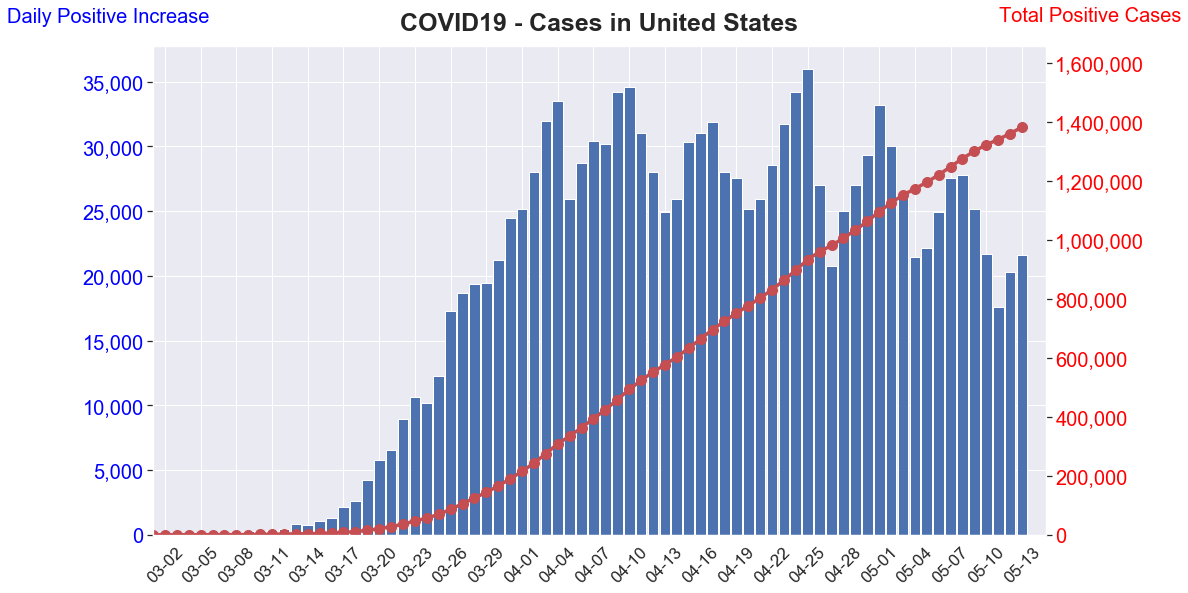

In [61]:
usa_cases_ts()

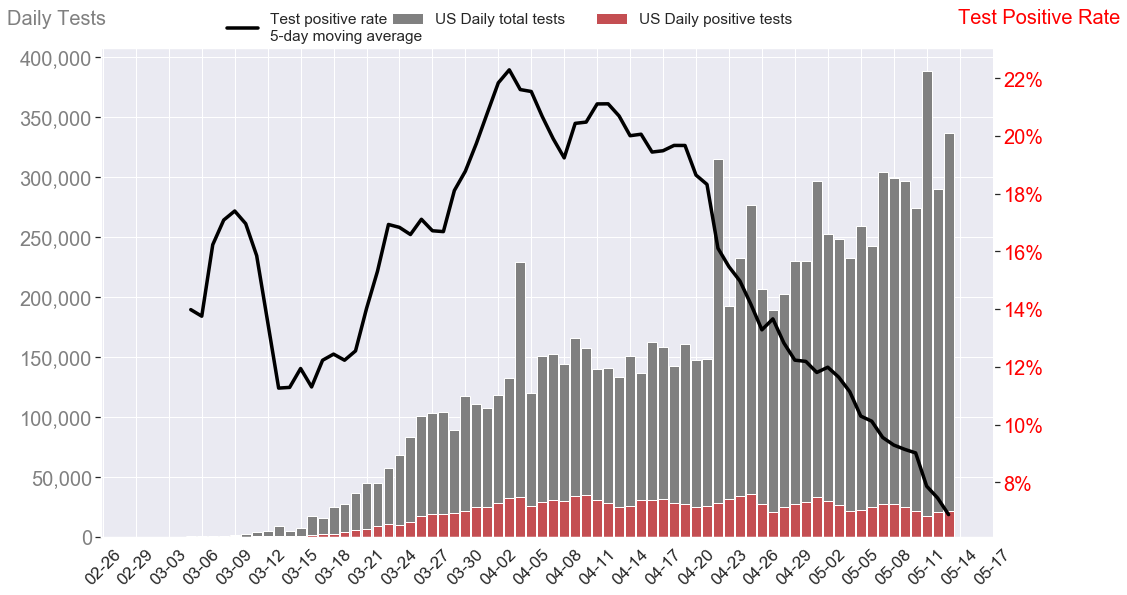

In [62]:
test_positive_rate_plot()

In [63]:
usa_worst_s = usa_covid19.groupby('state').first()[['positive']].sort_values(by='positive',ascending=False)
usa_worst_s['Label'] = usa_worst_s.index + "\n" + usa_worst_s['positive']\
.apply(lambda x : "{:,}".format(x))

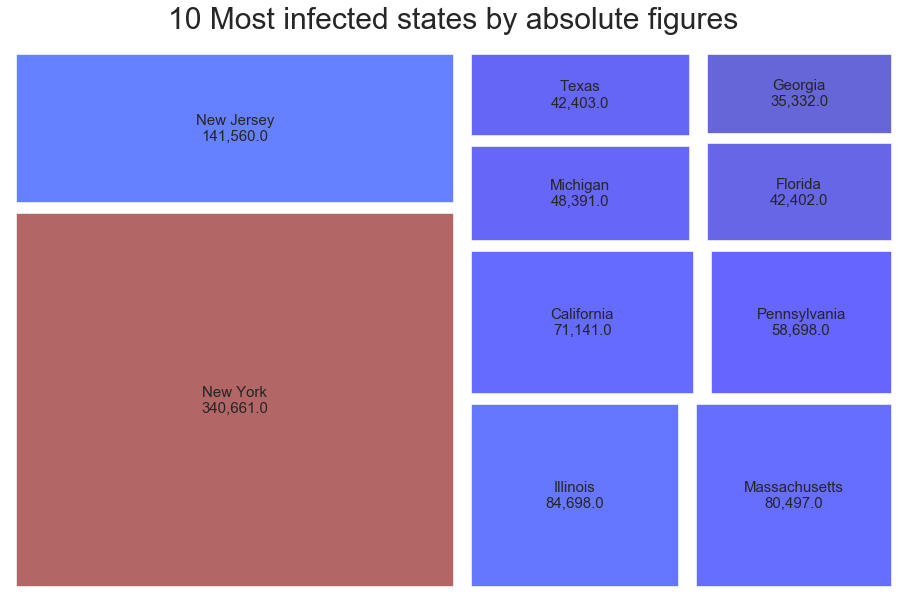

In [64]:
usa_worst_s = usa_covid19.groupby('state').first()[['positive']].sort_values(by='positive',ascending=False).head(10)
usa_worst_s['Label'] = usa_worst_s.index + "\n" + usa_worst_s['positive']\
.apply(lambda x : "{:,}".format(x))
usa_worst_s = usa_worst_s[usa_worst_s['positive'] > 0]
plt.figure(figsize=(16,10))
plt.axis('off')
mini = min(worst_countries_cases['TotalCases'])
maxi = max(worst_countries_cases['TotalCases'])
# Finding Colors for each tile
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
cmap = matplotlib.cm.jet
colors = [cmap(norm(value)) for value in worst_countries_cases['TotalCases']]
squarify.plot(usa_worst_s['positive'], label=usa_worst_s['Label'],color=colors, alpha=0.6, pad=True,
              text_kwargs={'fontsize':15});
plt.title('10 Most infected states by absolute figures', pad=20, fontsize=30);


In [65]:
usa_t5 = pd.DataFrame(usa_covid19[usa_covid19['date'] > '2020-03-01'].pivot_table(index='date',values='positive',
          columns=['state'])[-1:].T).nlargest(5,usa_covid19.date[1])
# usa_t10.index = usa_t10.index.map(states)
usa_t5.columns=['TotalCases']
usa_t5

TotalCases
state                    
New York         340661.0
New Jersey       141560.0
Illinois          84698.0
Massachusetts     80497.0
California        71141.0

In [66]:
us_t3 = pd.DataFrame(usa_covid19[usa_covid19['date'] > '2020-03-01'].pivot_table(index='date',values='positive',
          columns=['state'])[-1:].T).nlargest(3,usa_covid19.date[1])
us_t3.columns=['TotalCases']


In [67]:
plt.style.use('default')


In [68]:
test = usa_covid19[(usa_covid19['date'] > '2020-03-01') & (usa_covid19['state'].isin(usa_t5.index.tolist()))].pivot_table\
            (index='date',values='positive', columns='state')

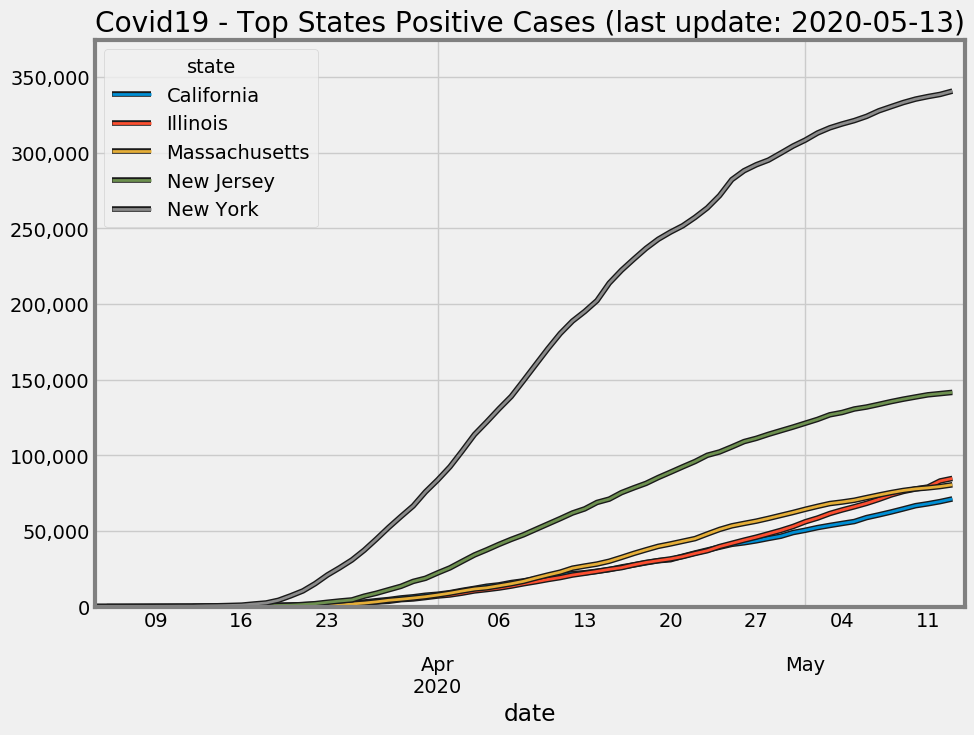

In [69]:
plt.style.use('fivethirtyeight')

usa_tspc = usa_covid19[(usa_covid19['date'] > '2020-02-01') & (usa_covid19['state'].isin(usa_t5.index.tolist()))].pivot_table\
           (index='date',values='positive', columns='state')
ax = usa_tspc.plot(figsize=(10,7), lw=2,path_effects=[path_effects.Stroke(linewidth=4, foreground='k'), path_effects.Normal()])
plt.title(f'Covid19 - Top States Positive Cases (last update: {usa_covid19.date[0].date()})');
plt.xlim(usa_tspc.index.min(), usa_tspc.index.max() + datetime.timedelta(1))
plt.ylim(0,usa_tspc.max().max()*1.1)

ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))); 
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')

### Top States Daily Positive Cases

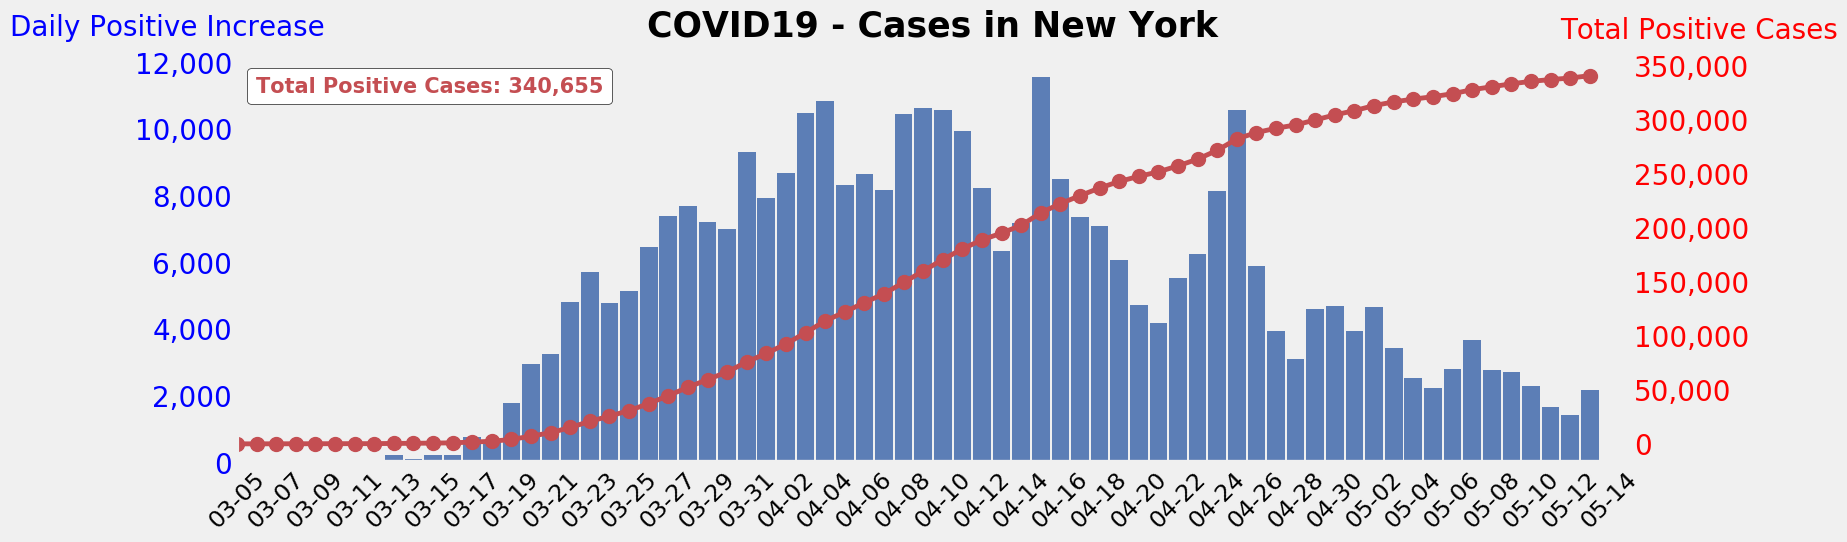

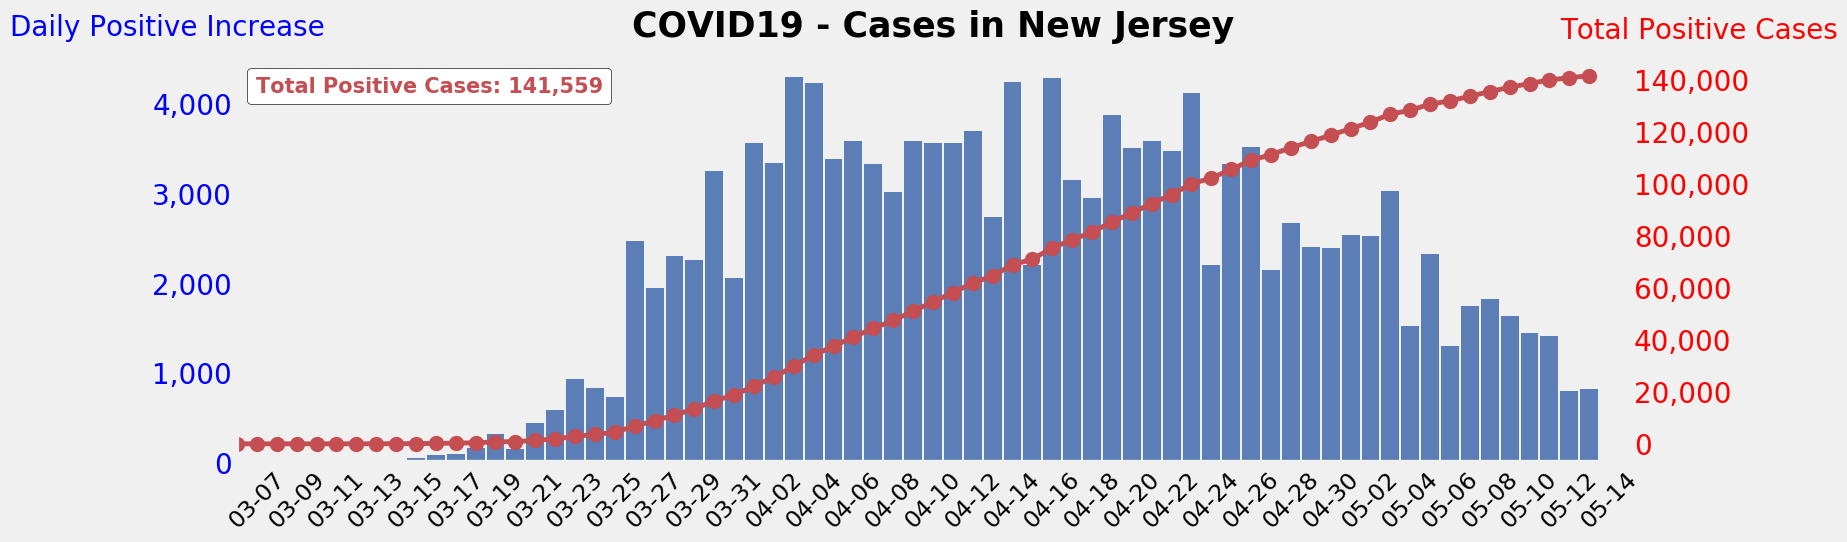

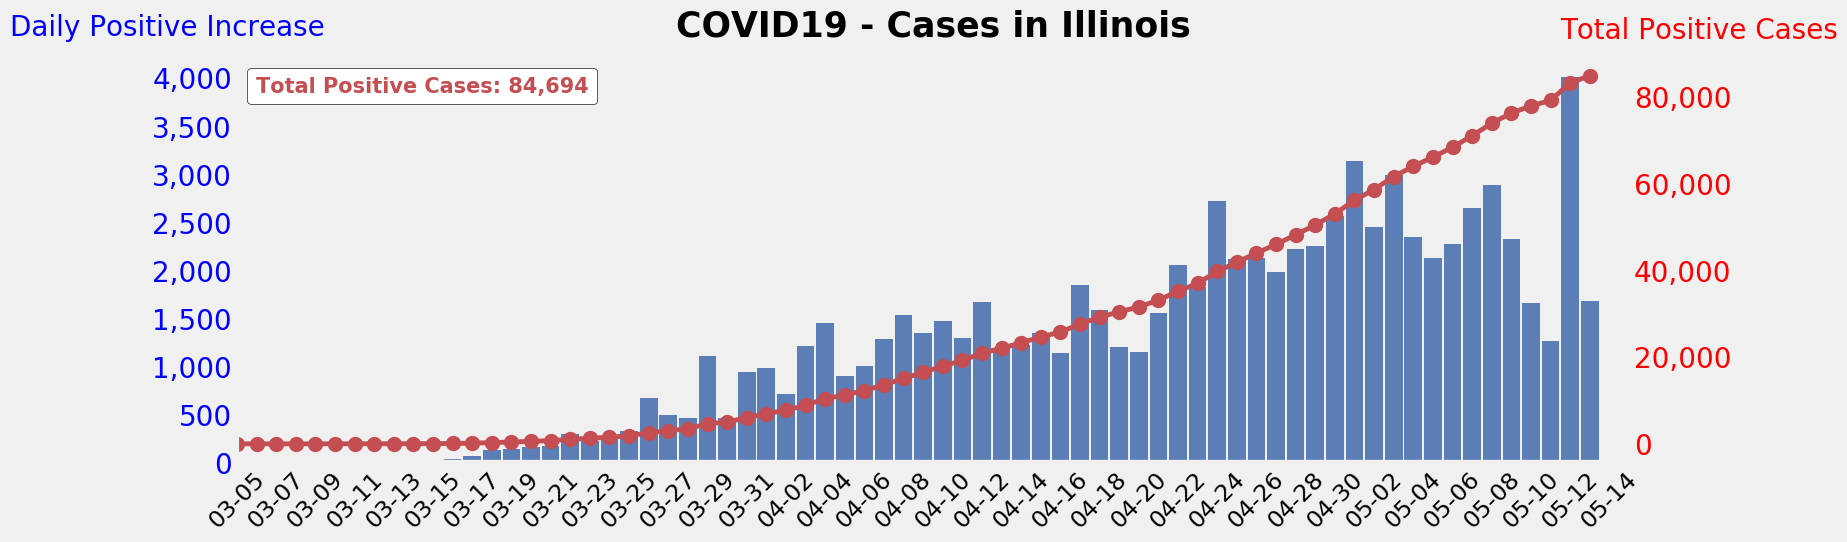

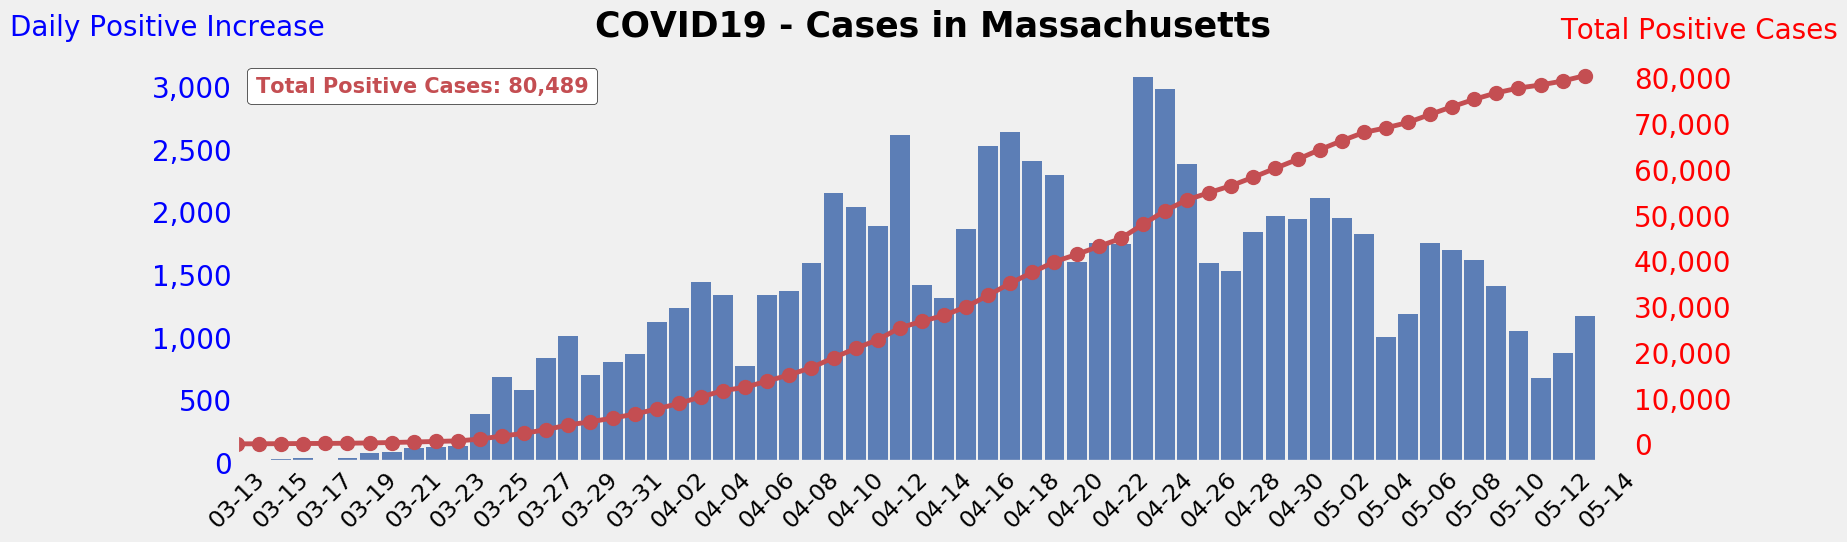

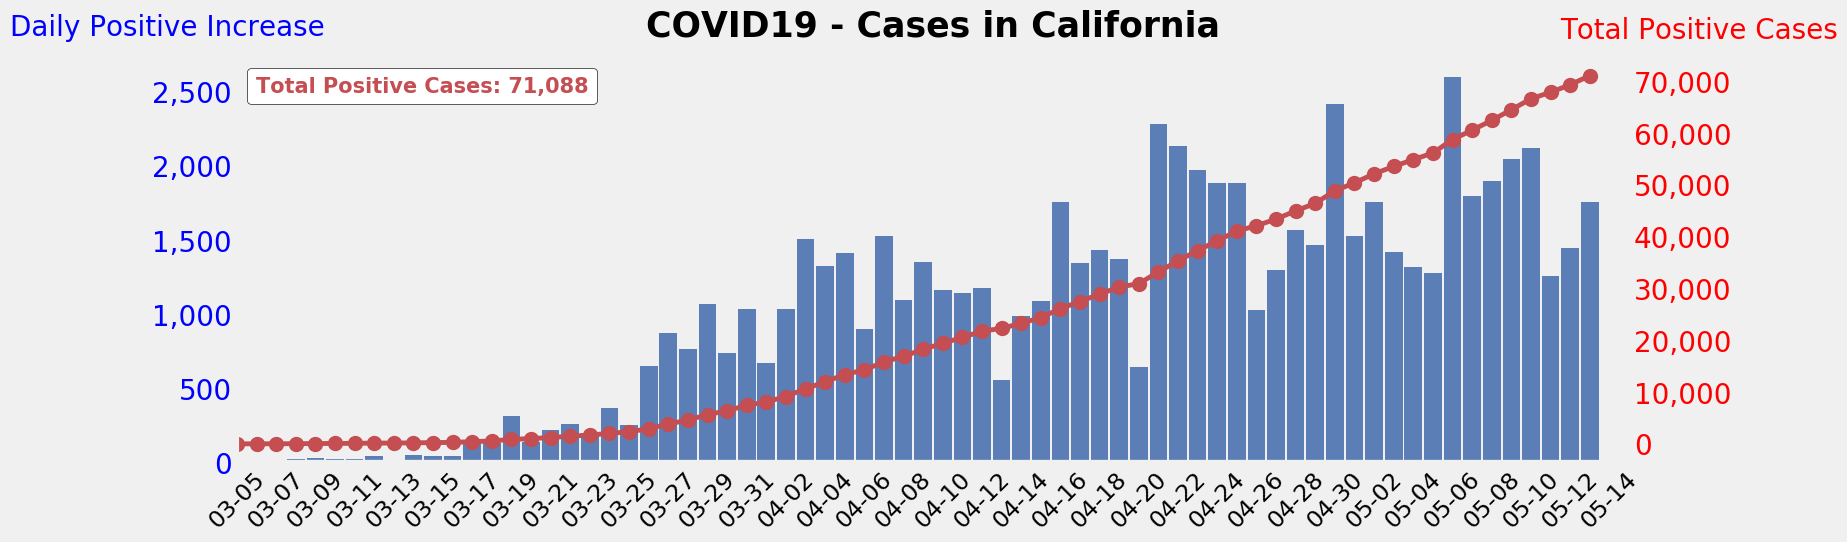

In [70]:
for state in usa_t5.index:
    
    positive_cases_plot(usa_covid19,state)

In [71]:
def positive_cases_plot(df,state):
    
    state_c = df[df['state'] ==state][['date','positiveIncrease','deathIncrease']].sort_values(by='date')\
    .reset_index(drop=True).dropna()
    state_c['total_cases'] = state_c['positiveIncrease'].cumsum()
    plt.style.use('seaborn-deep')
    fig, ax = plt.subplots(figsize=(16,5))
    plt.bar(state_c['date'], height=state_c['positiveIncrease'], width=0.9);
    plt.xlim(state_c['date'].min().date(),state_c['date'].max().date() + datetime.timedelta(2))
    plt.xticks(fontsize=17,rotation=45);
    plt.yticks(color='blue', size=20)
    plt.margins(x=0.04)
    plt.title(f'COVID19 - Cases in {state}', fontsize=20,pad=12,weight ='semibold')
    ax.set_ylabel('Positive Increase', fontsize=16, color='blue', size=25)

    ax2 = ax.twinx()
    plt.plot(state_c['date'],state_c['total_cases'], lw=3.5, color='r', marker='.', markersize=20)
    plt.yticks(color='red', size=20)
    plt.ylim(0,(state_c['total_cases'].max()*1.2))
    ax2.set_ylabel('Total Positive Cases', fontsize=16, color='red', size=25, rotation=270, labelpad=35)
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))); 
    ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))));
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))

In [72]:
usa_covid19lw = usa_covid19[usa_covid19['date'] < (usa_covid19.date.max()-datetime.timedelta(6))]

In [73]:
usa_top20 = usa_covid19.groupby('state')[['positive']].first().sort_values(by='positive').reset_index()[-20:]

In [74]:
print('* Replace nan with 0 for missing values in the recovered column');
usa_covid19.groupby('state')[['positive','death','recovered']].first().sort_values(by='positive', ascending=False)\
.fillna(0).style.format({'positive':'{:,.0f}', 'death':'{:,.0f}', 'recovered':'{:,.0f}'})\
.background_gradient(cmap='Blues',subset=["positive"])\
.background_gradient(cmap='OrRd',subset=["death"])\
.background_gradient(cmap='Greens',subset=["recovered"])\
.set_caption('US states')


* Replace nan with 0 for missing values in the recovered column


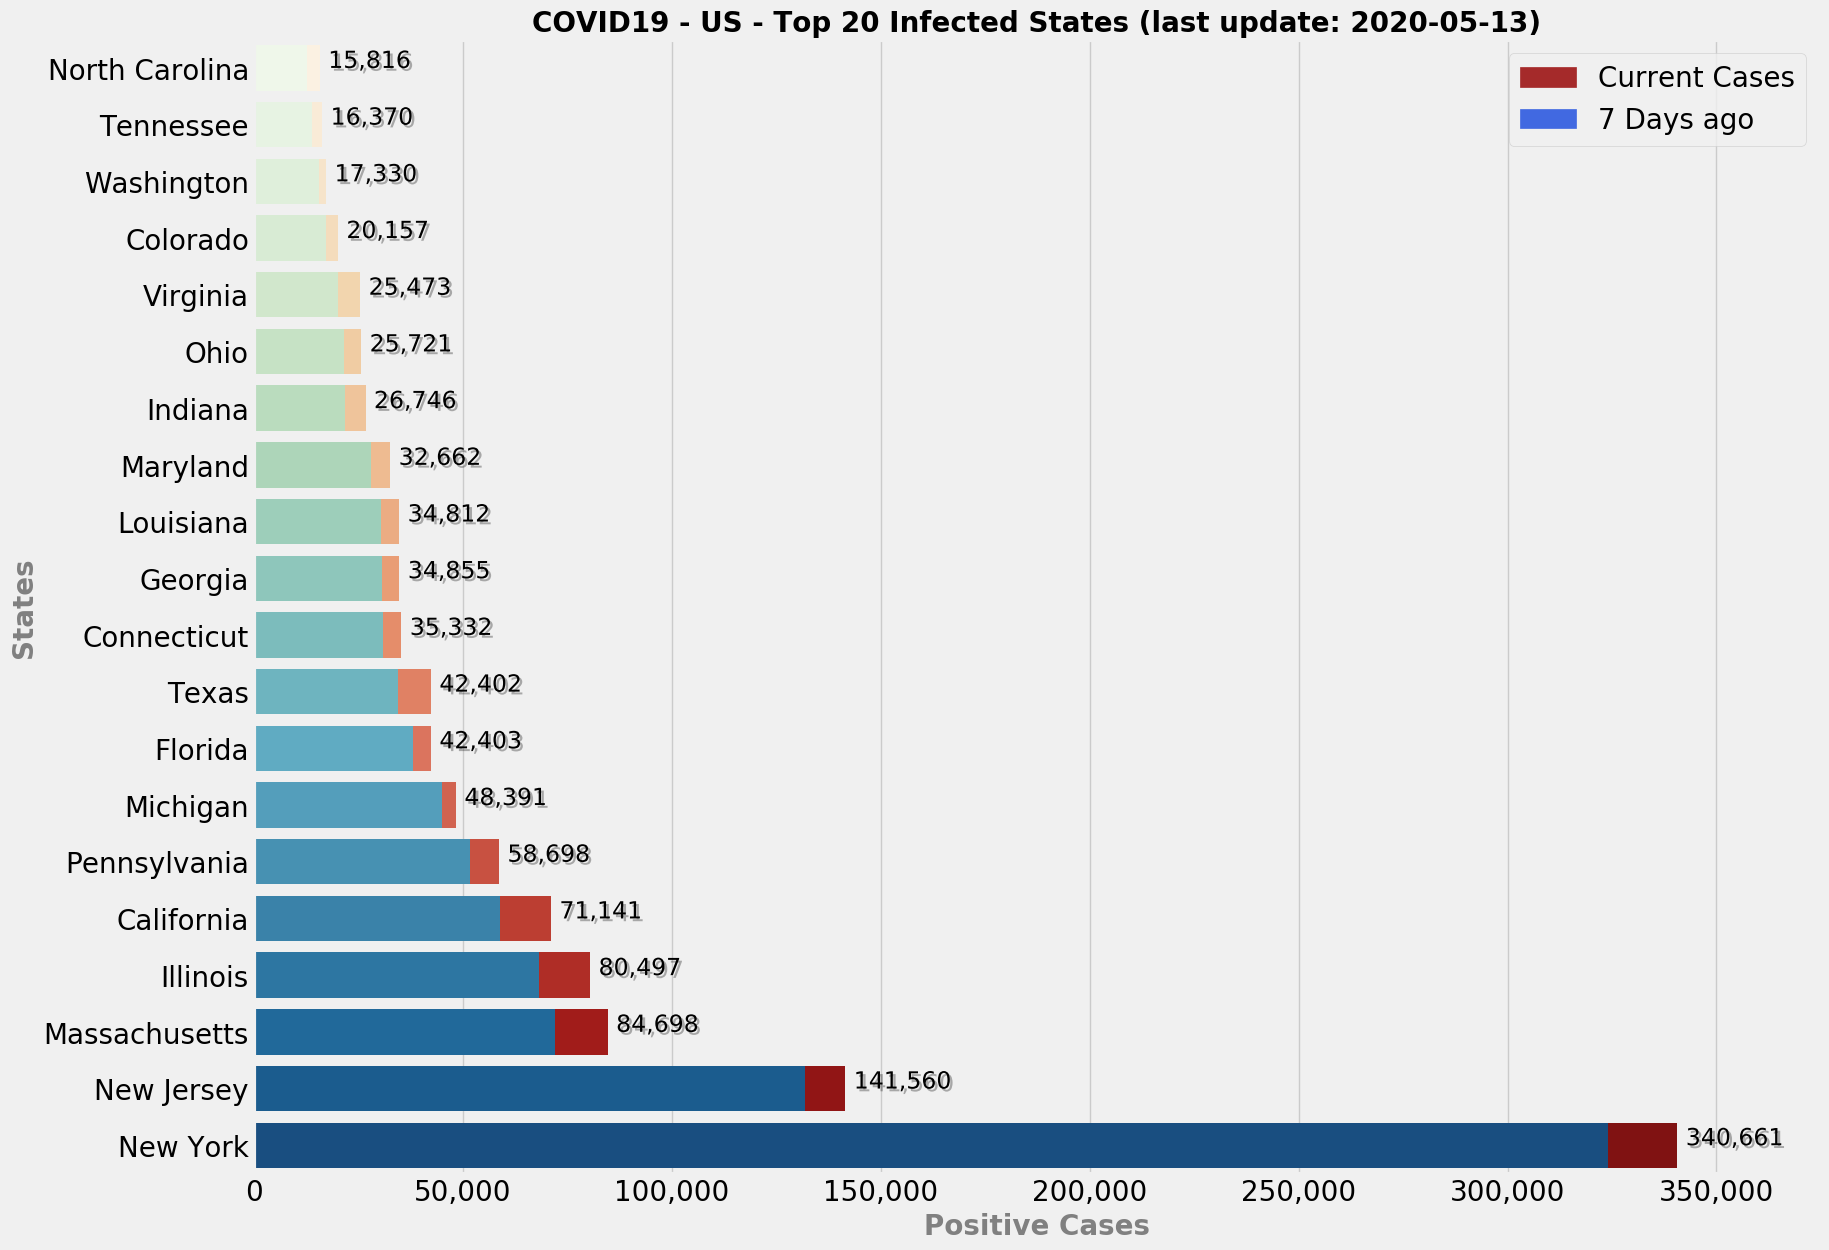

In [75]:
top_20_infected()

<b>And, Let's see the states with the highest rate of change for the last 7 days:</b>

In [76]:
usa_w_roc = usa_covid19.groupby('state')[['positive']].first()
usa_w_roc['weekly change'] = usa_covid19.groupby('state')[['positive']].first() - usa_covid19lw.groupby('state')\
[['positive']].first()
usa_w_roc['% change']  = (usa_covid19.groupby('state')[['positive']].first() / usa_covid19lw.groupby('state')[['positive']]\
                          .first()-1)
usa_w_roc = usa_w_roc.sort_values(by='% change', ascending=False).head(10)
usa_w_roc.style.format({'positive':'{:,.0f}', 'weekly change':'{:,.0f}','% change':'{:.01%}'}).background_gradient(cmap='Blues')

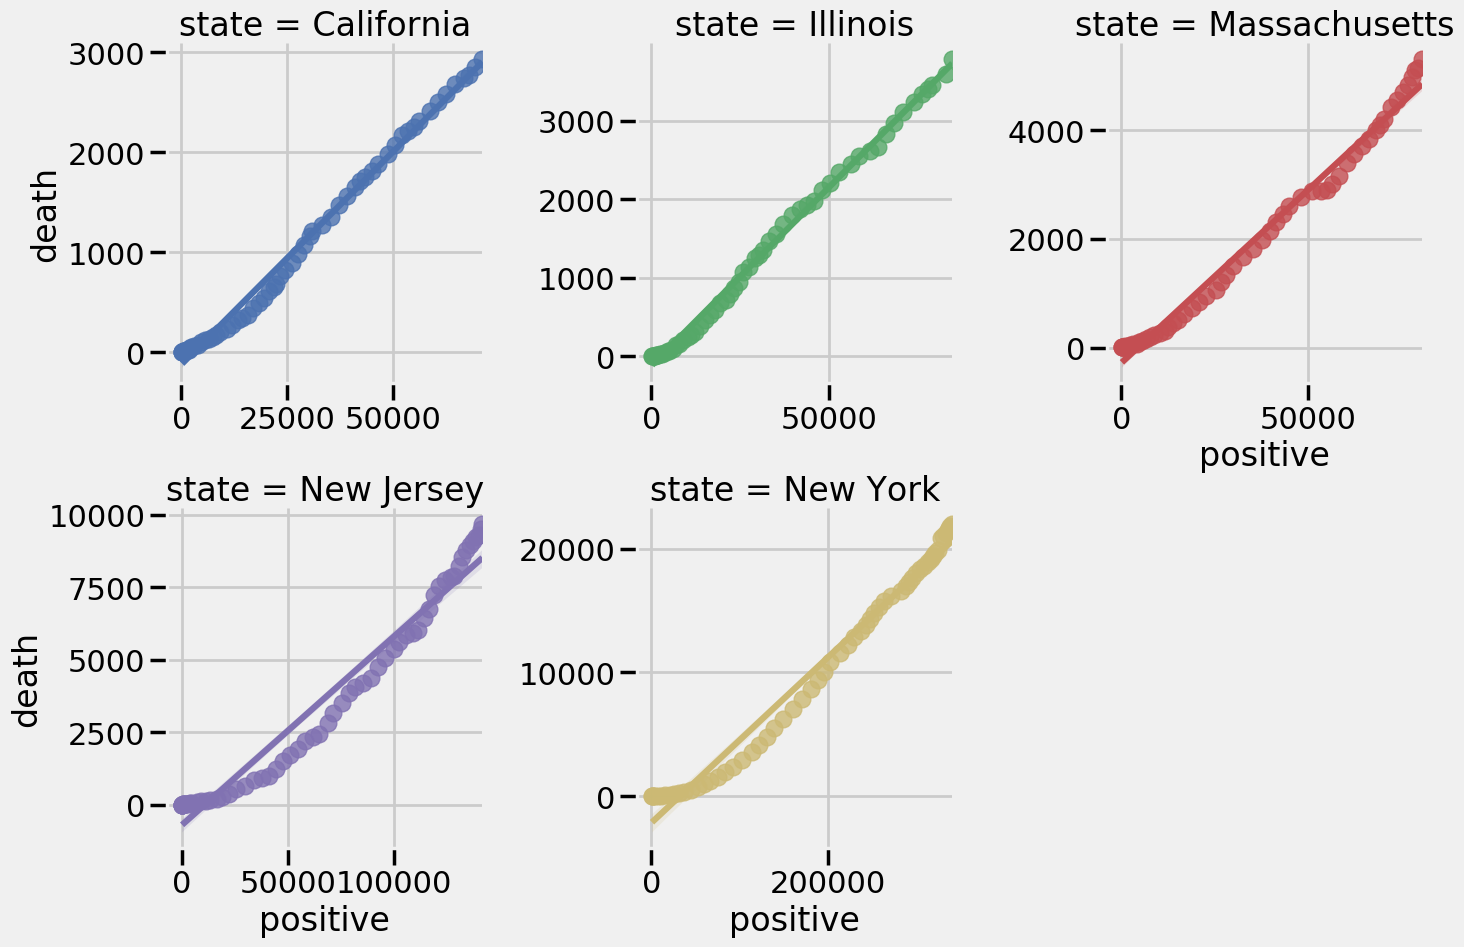

In [77]:
top_us_states_df = usa_covid19[usa_covid19['state'].isin(usa_t5.index.tolist())].copy()

# total deaths to positive cases in each top state
sns.lmplot(x='positive', y='death', col='state', hue='state', col_wrap=3,
           data=top_us_states_df,sharex=False,sharey=False);

![US states](https://assets.weforum.org/article/image/large_kPbdJNerlCdAz-8fizqPQGg3sSSKfnSyJSrstSJTpfY.jpg)    